# Imports

In [67]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import plotly.express as px
import plotly.graph_objects as go
sns.set(rc={'figure.figsize':(25,10)})
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error
import holidays

# Data pre-processing (Scaling)

In [97]:
df_for_scaling = pd.read_csv("../prepared_data/01_06_2021_to_20_06_2023_prepared_df.csv")

## Creating histograms

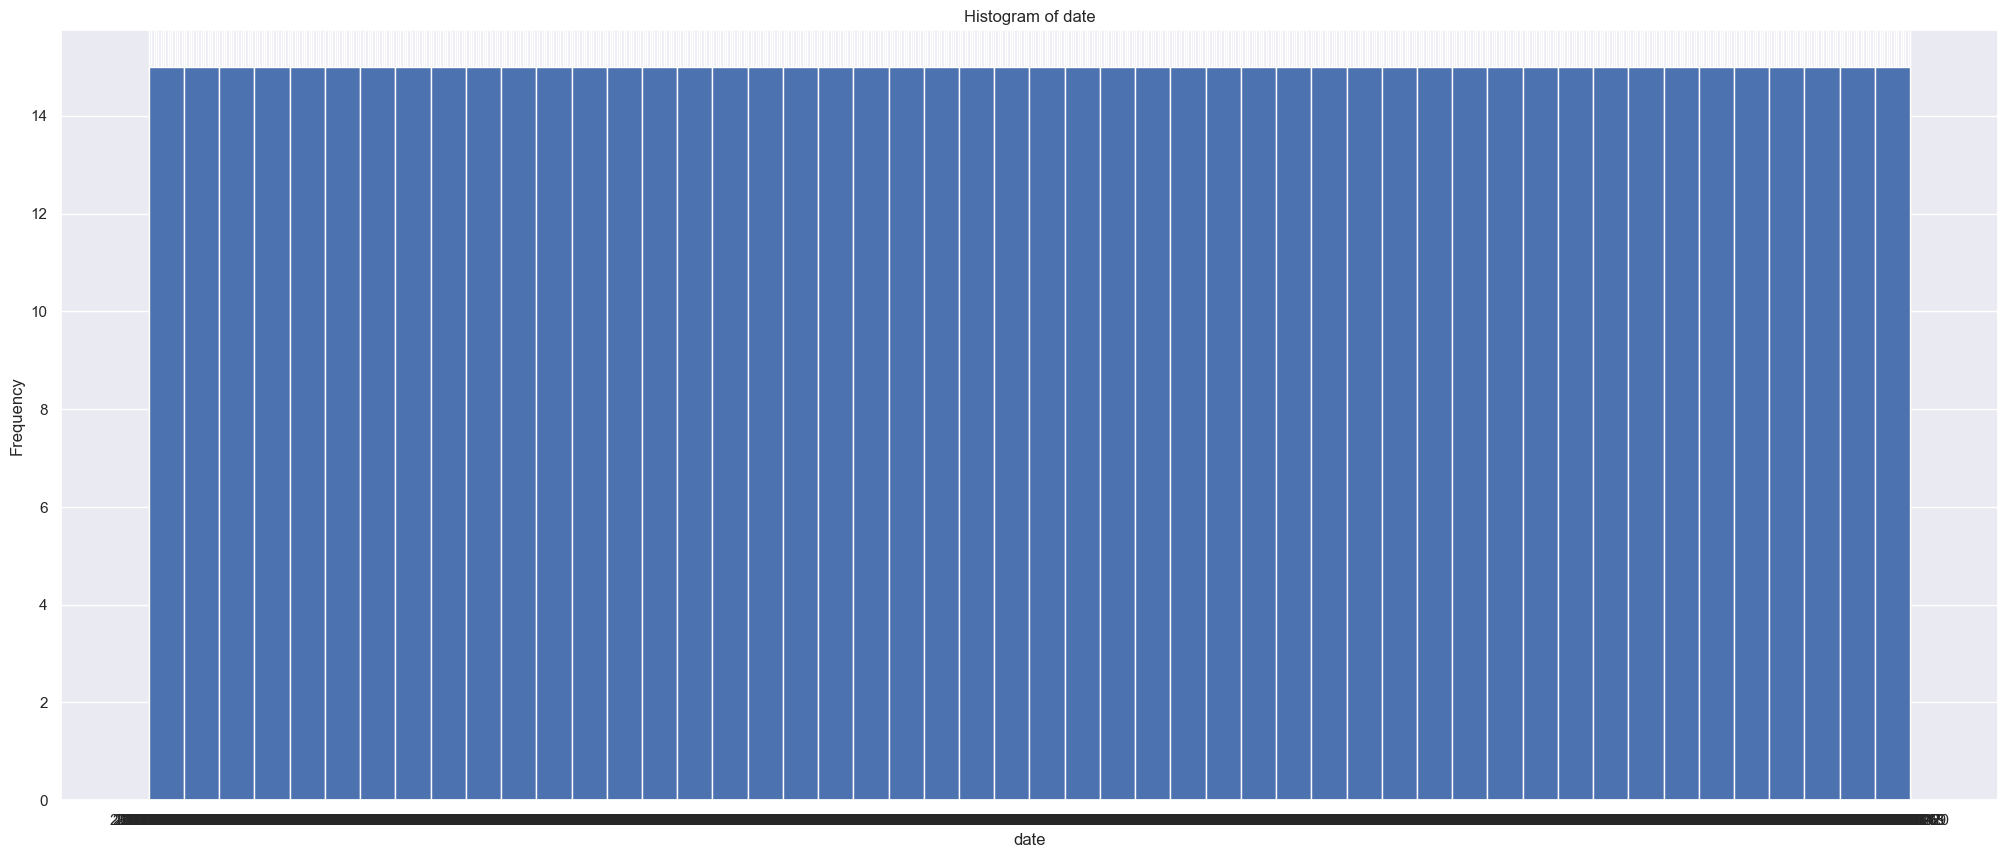

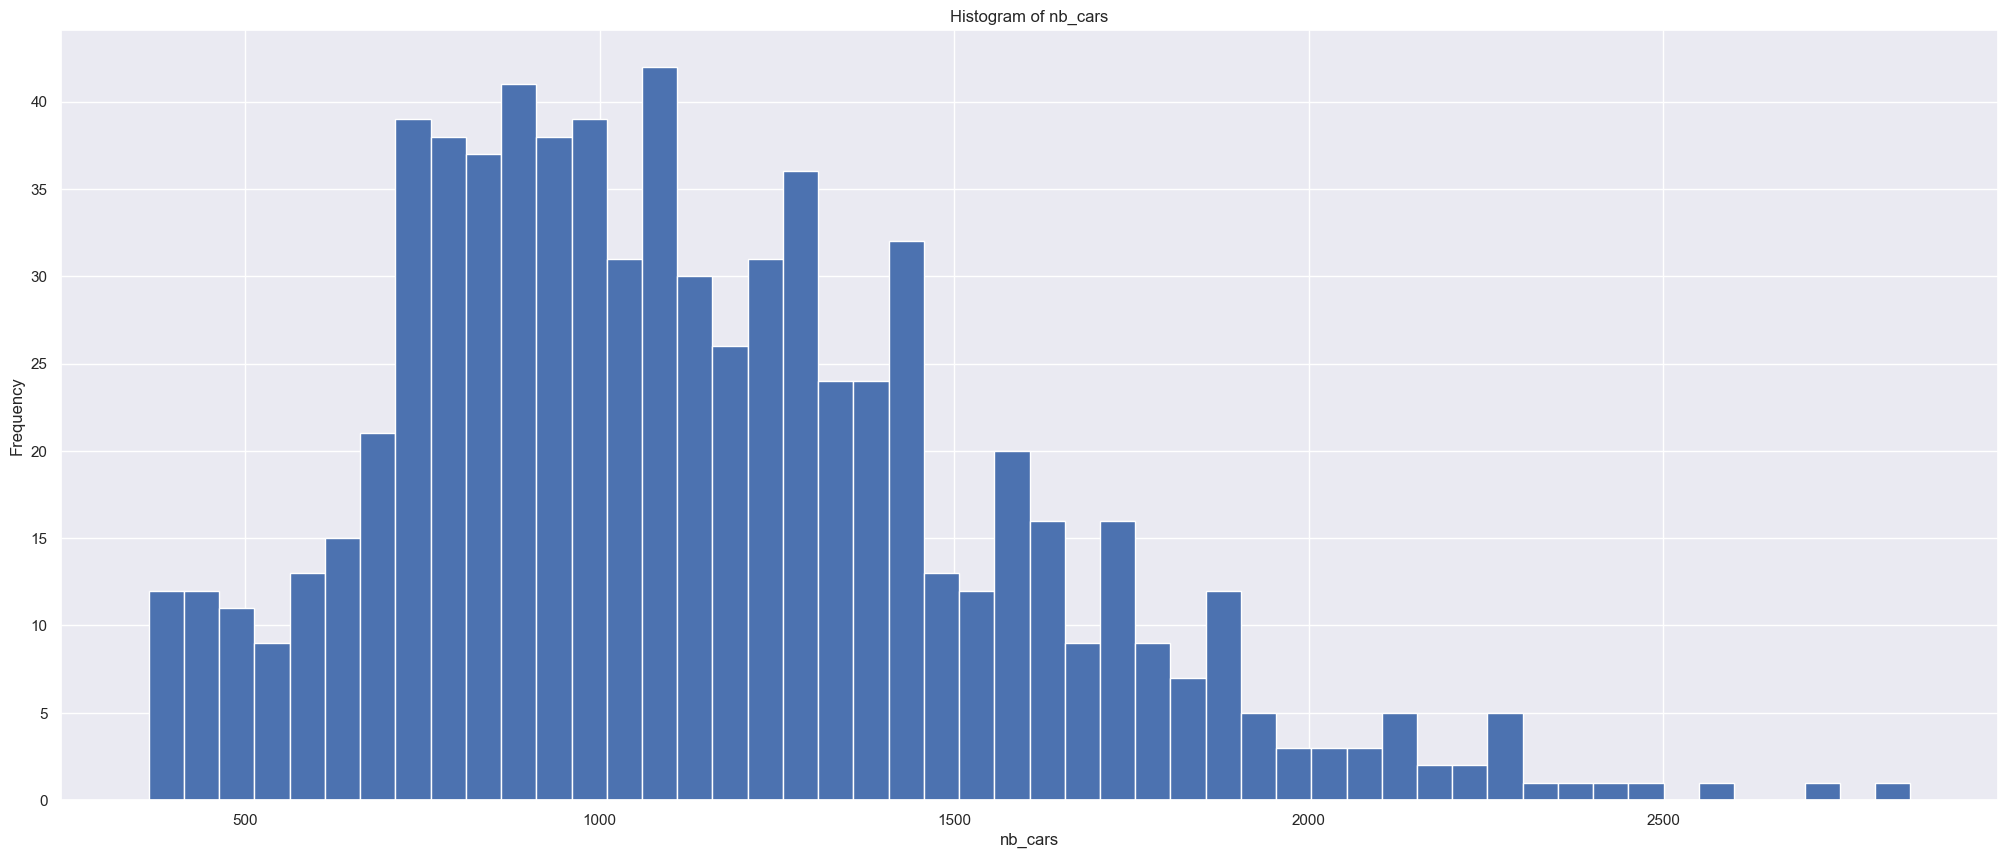

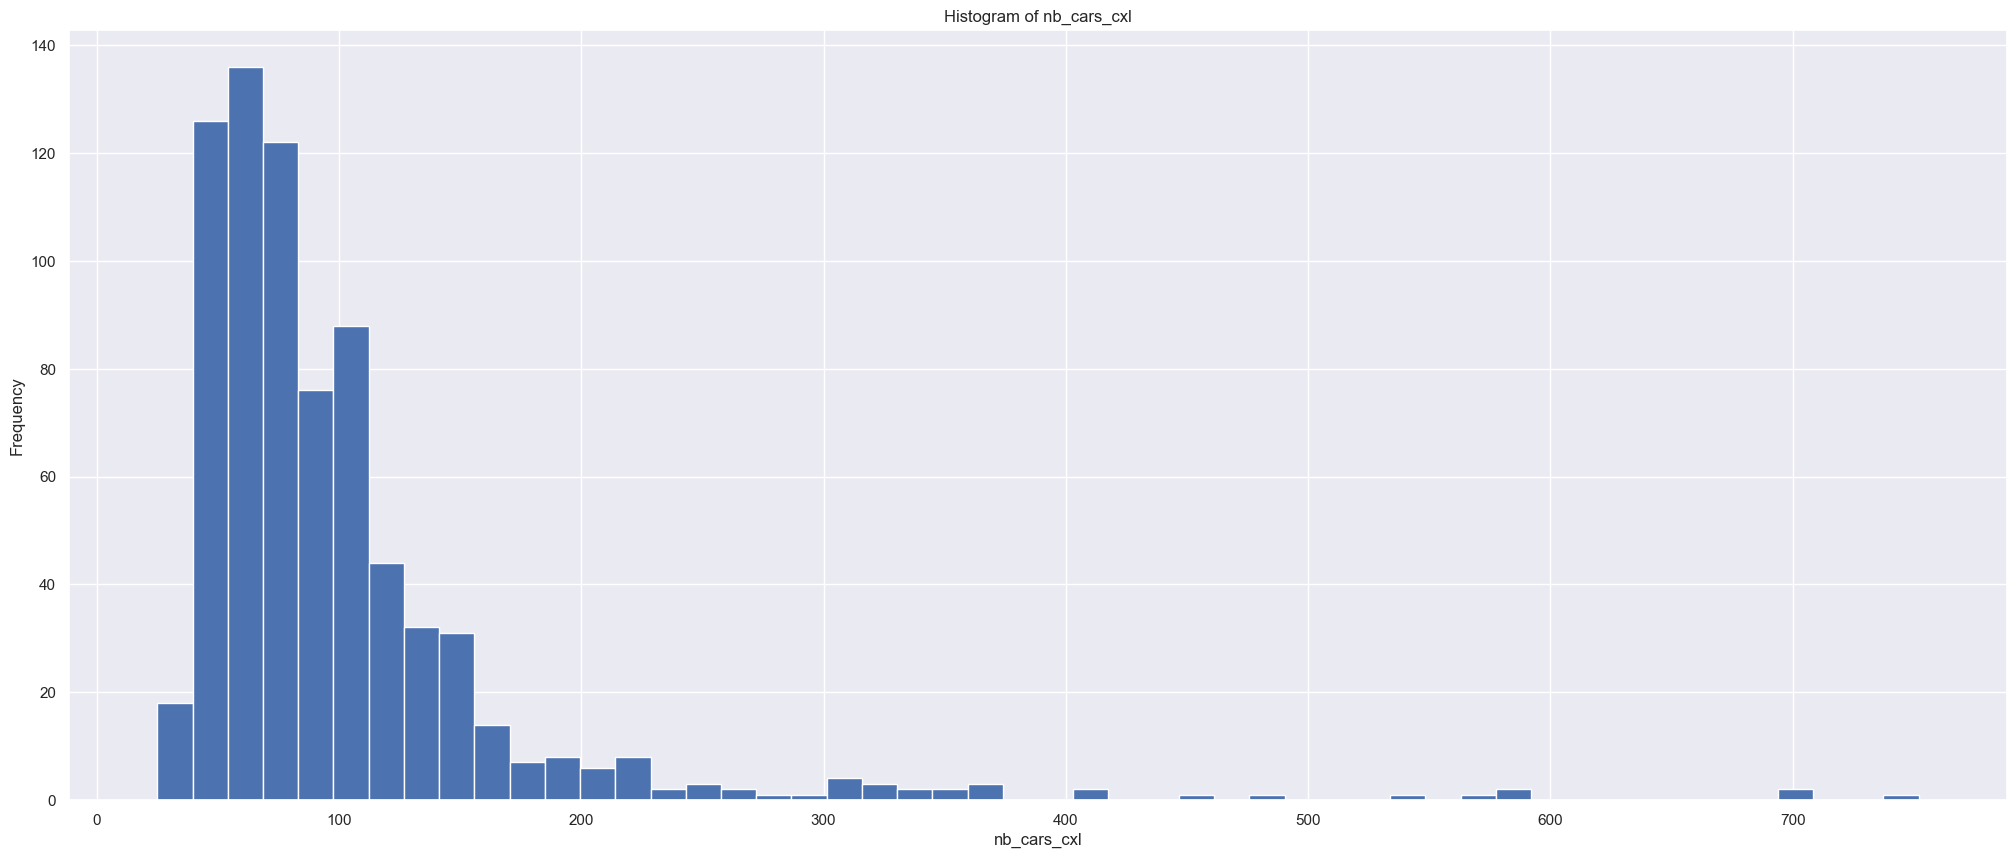

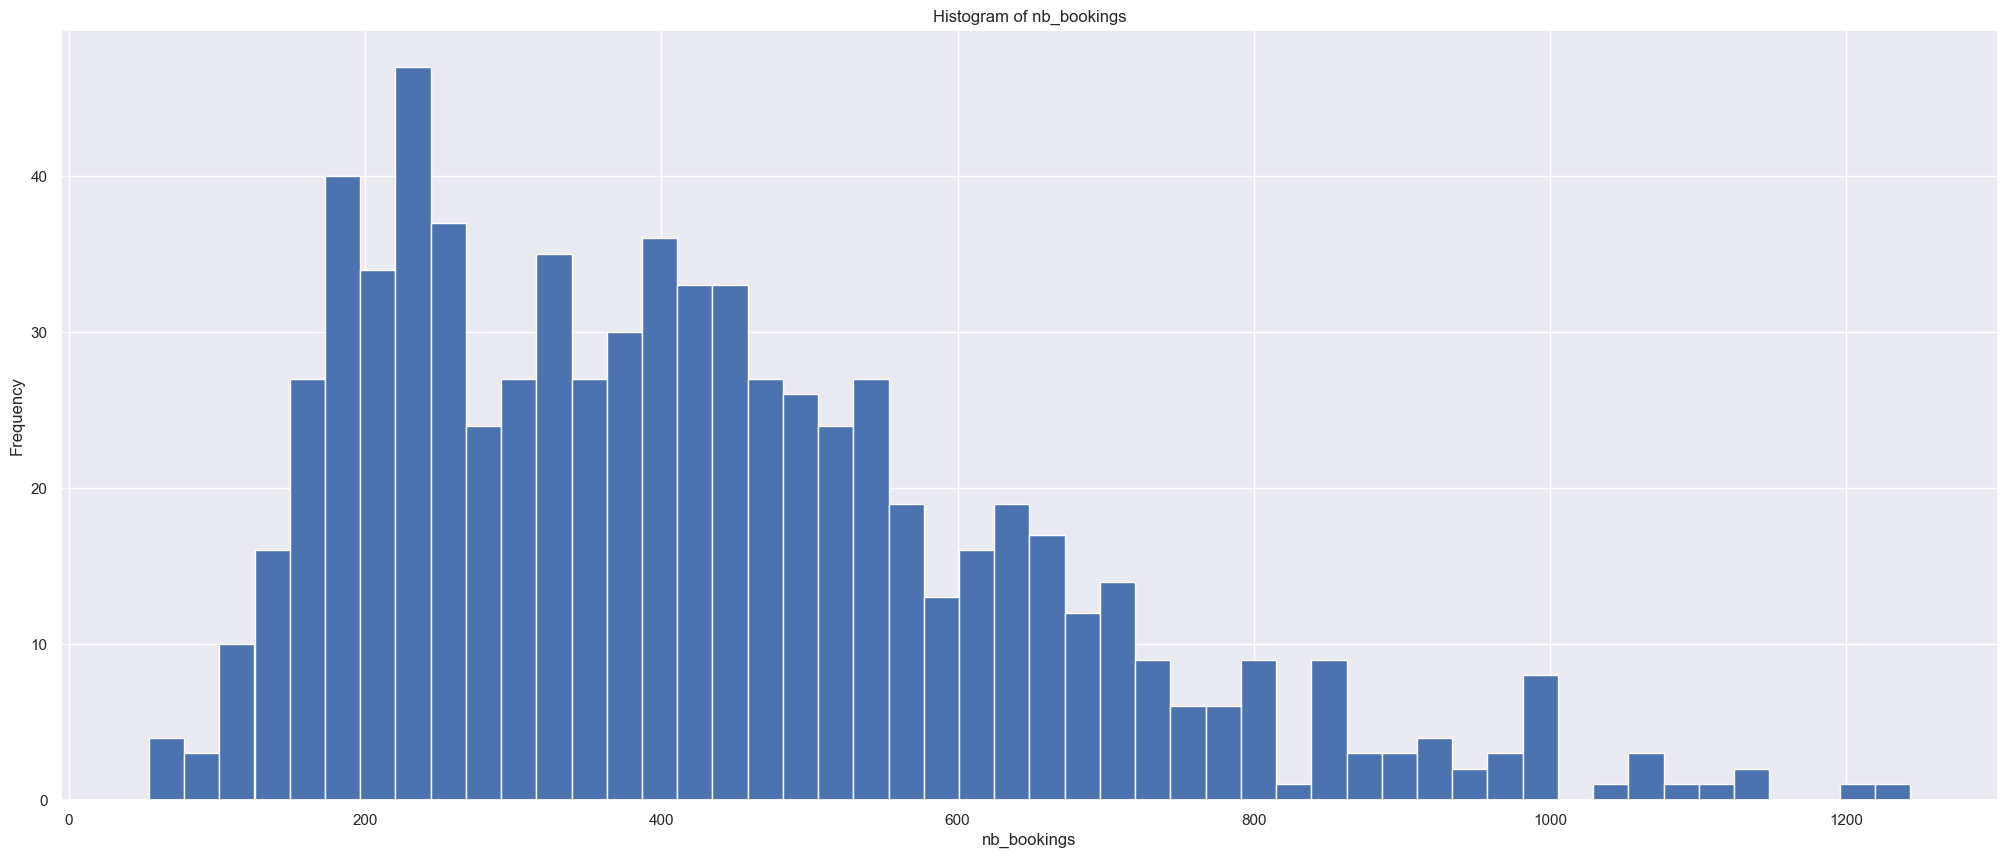

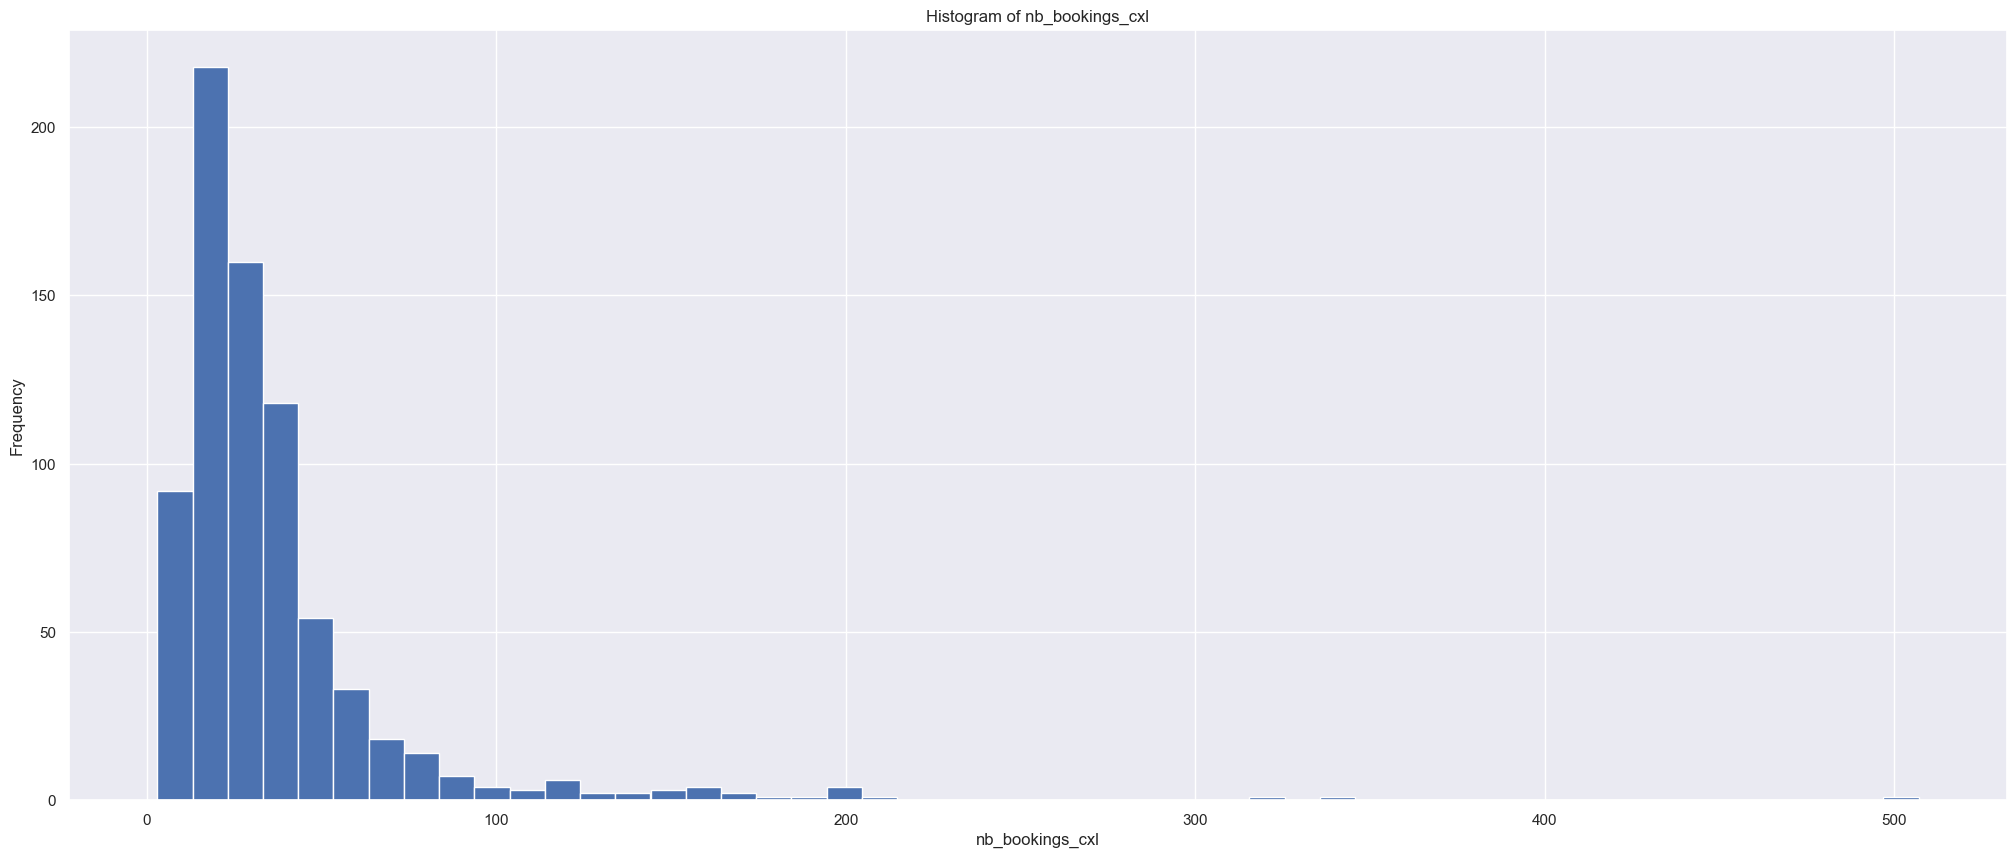

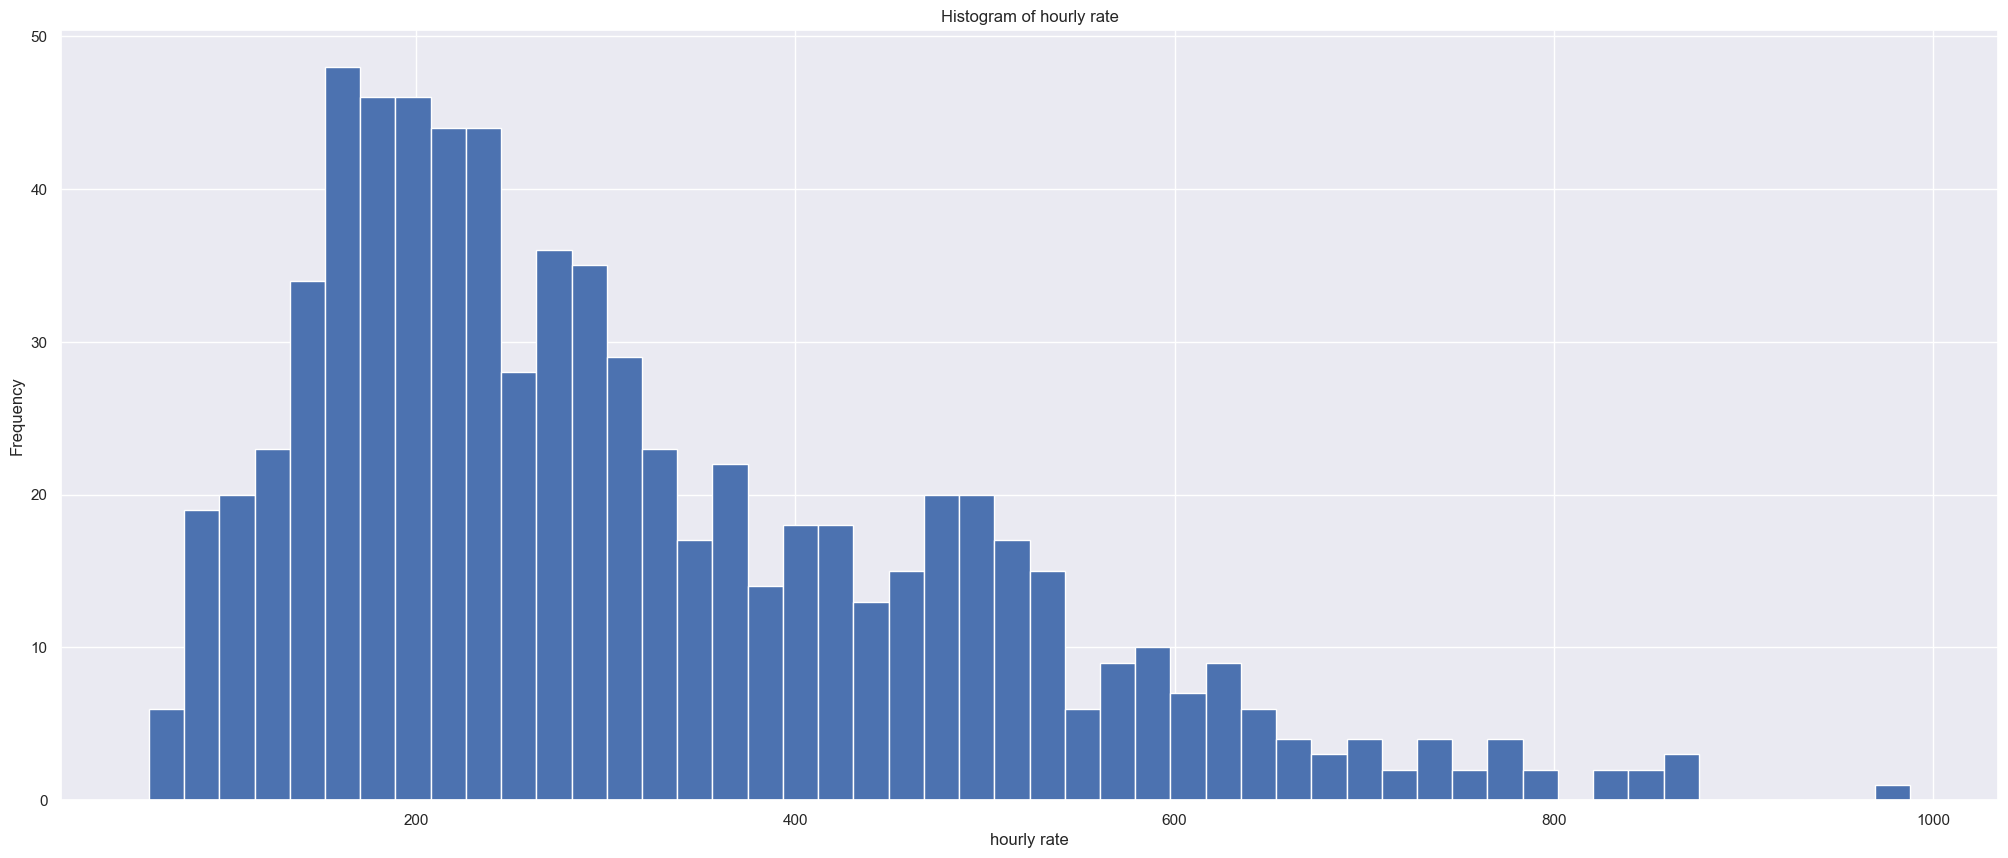

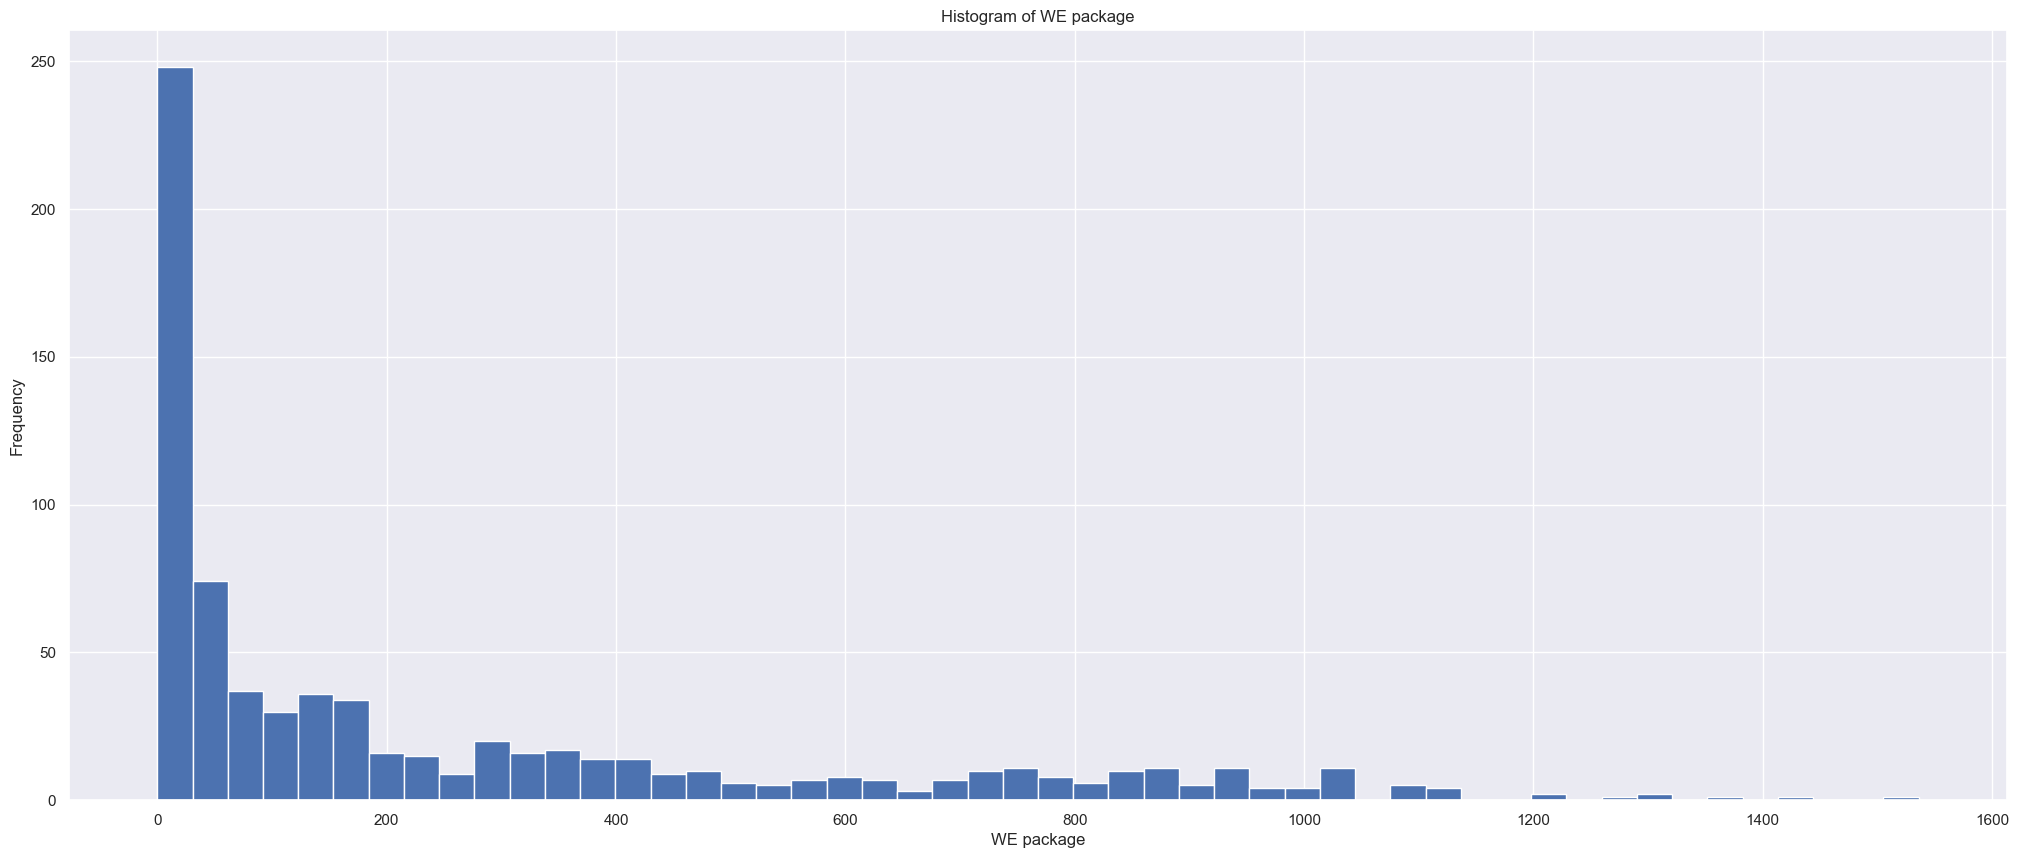

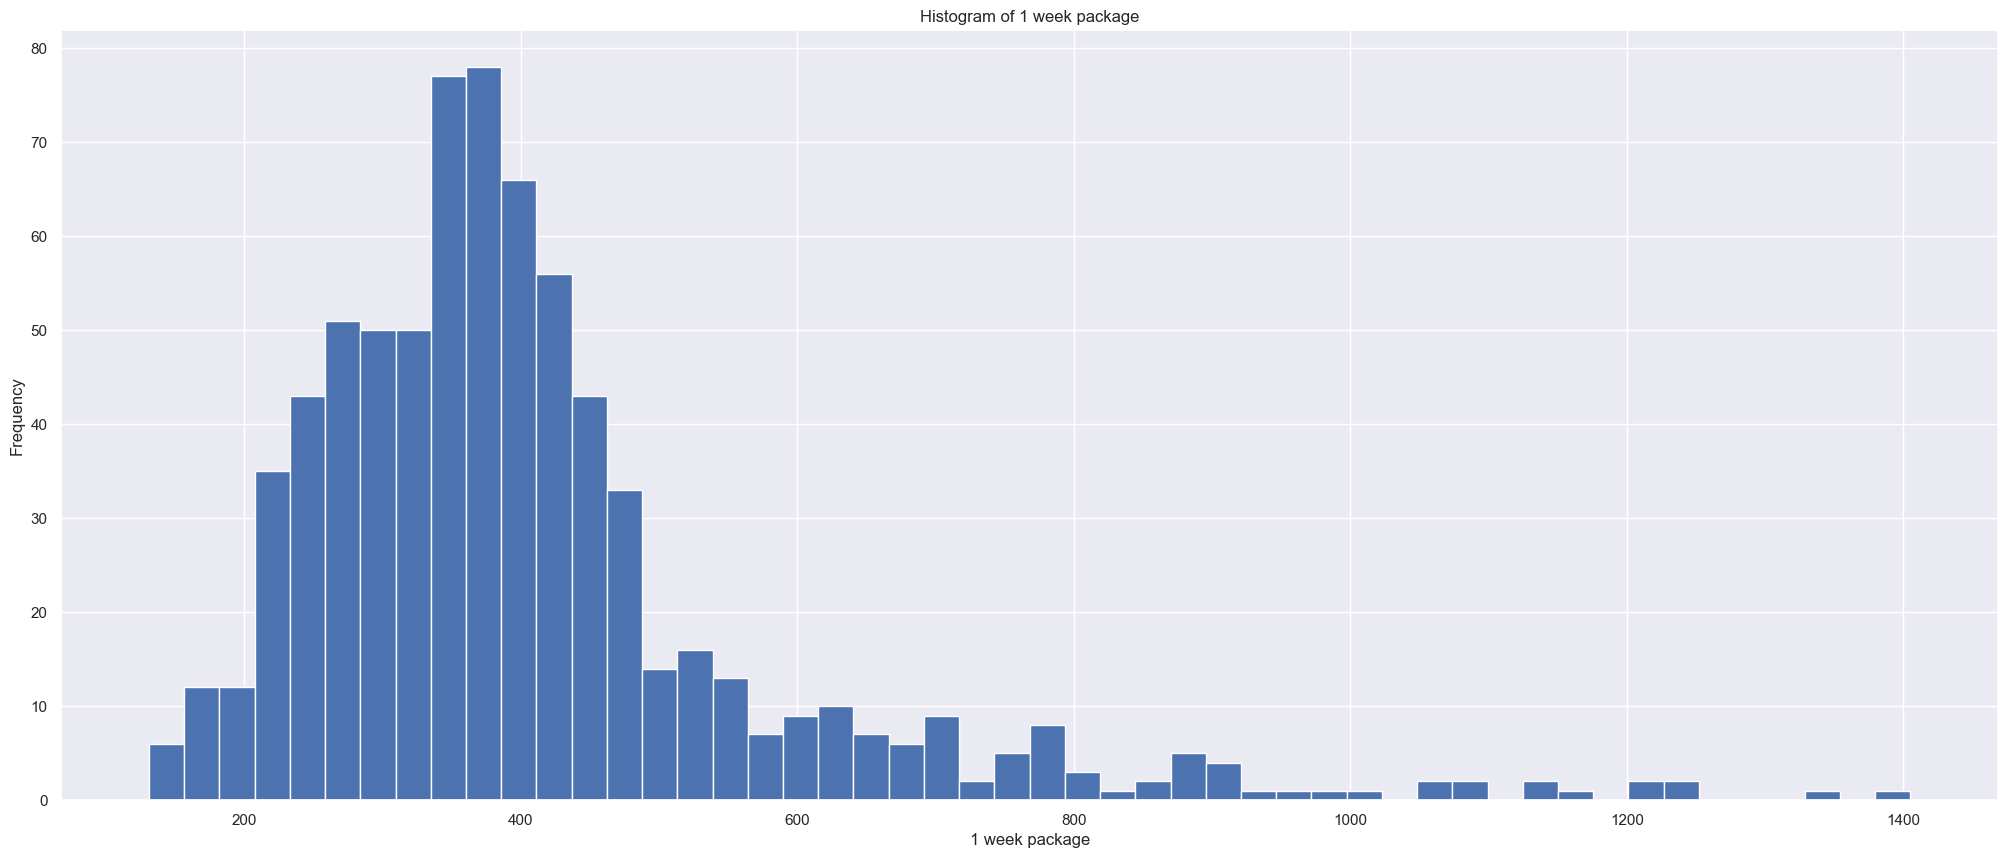

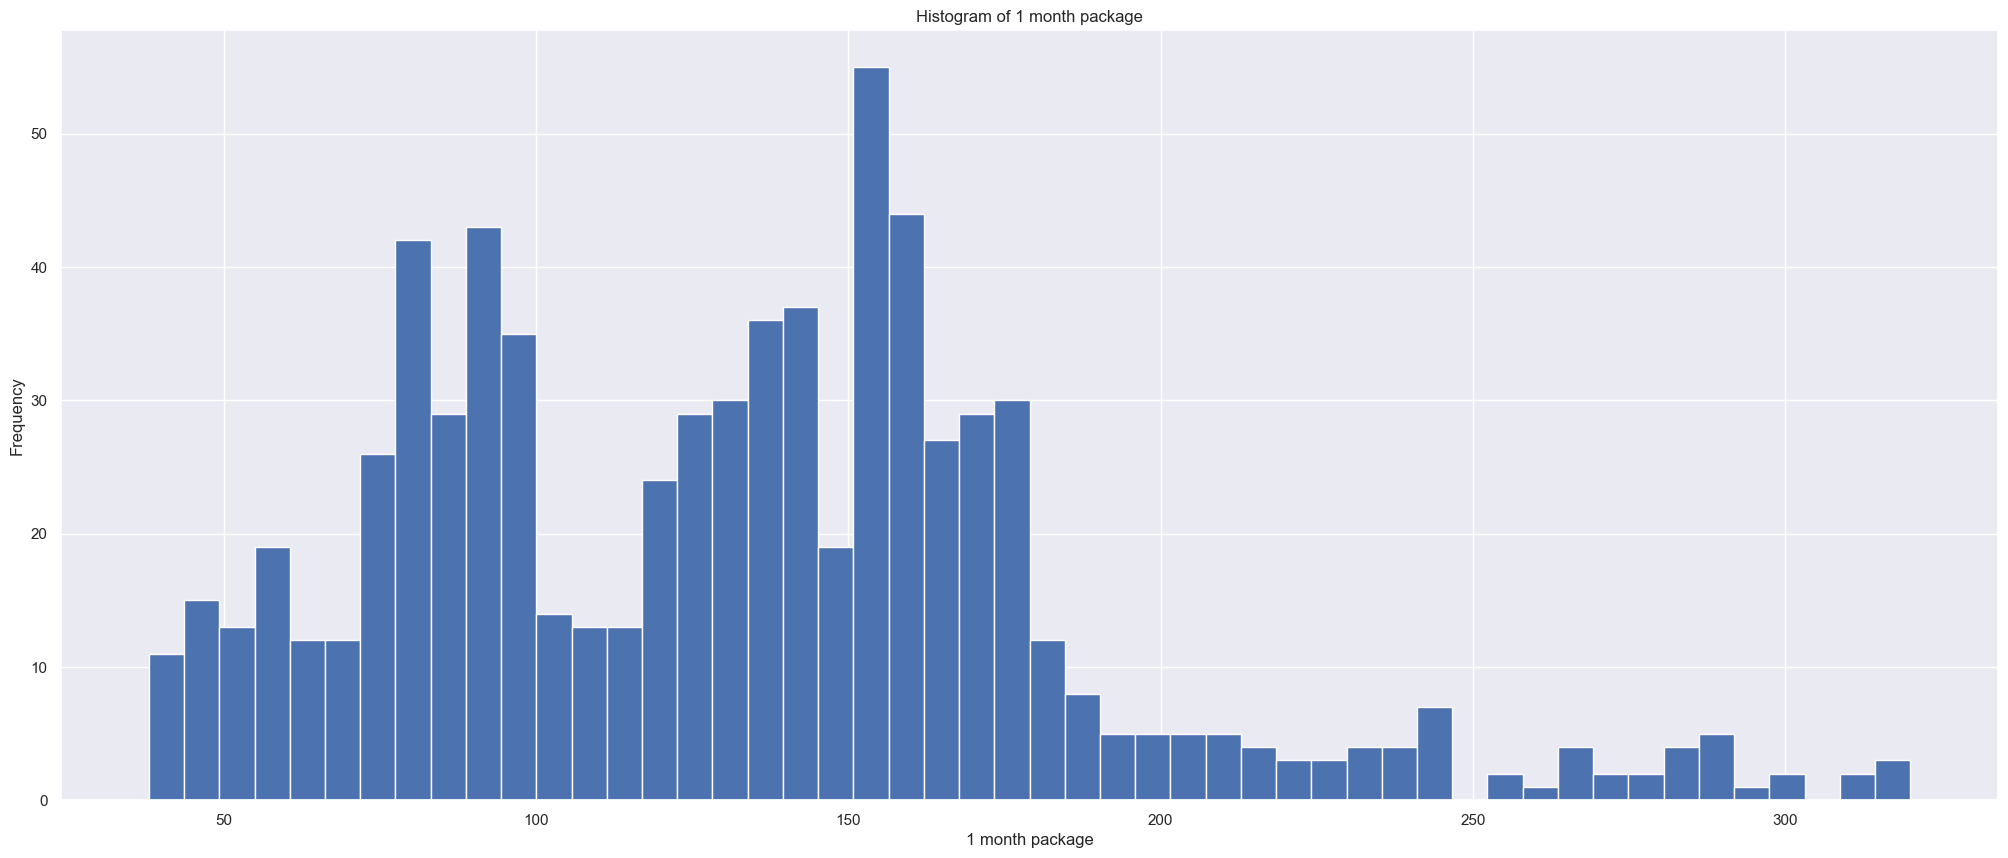

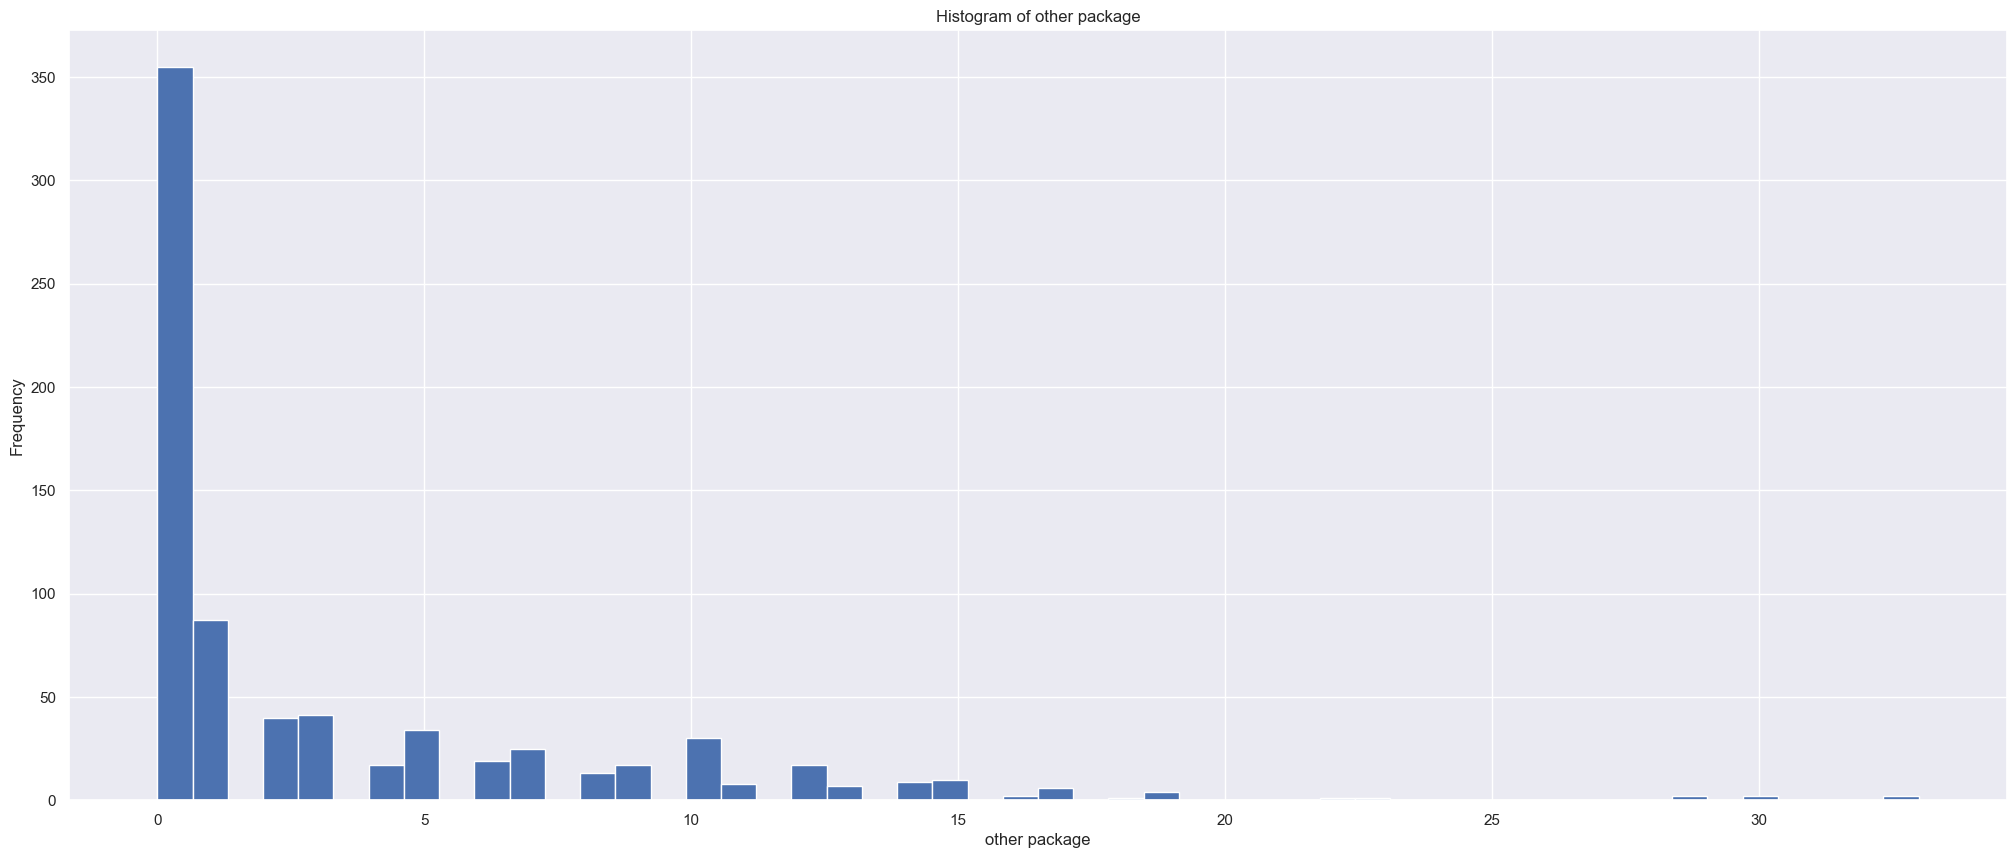

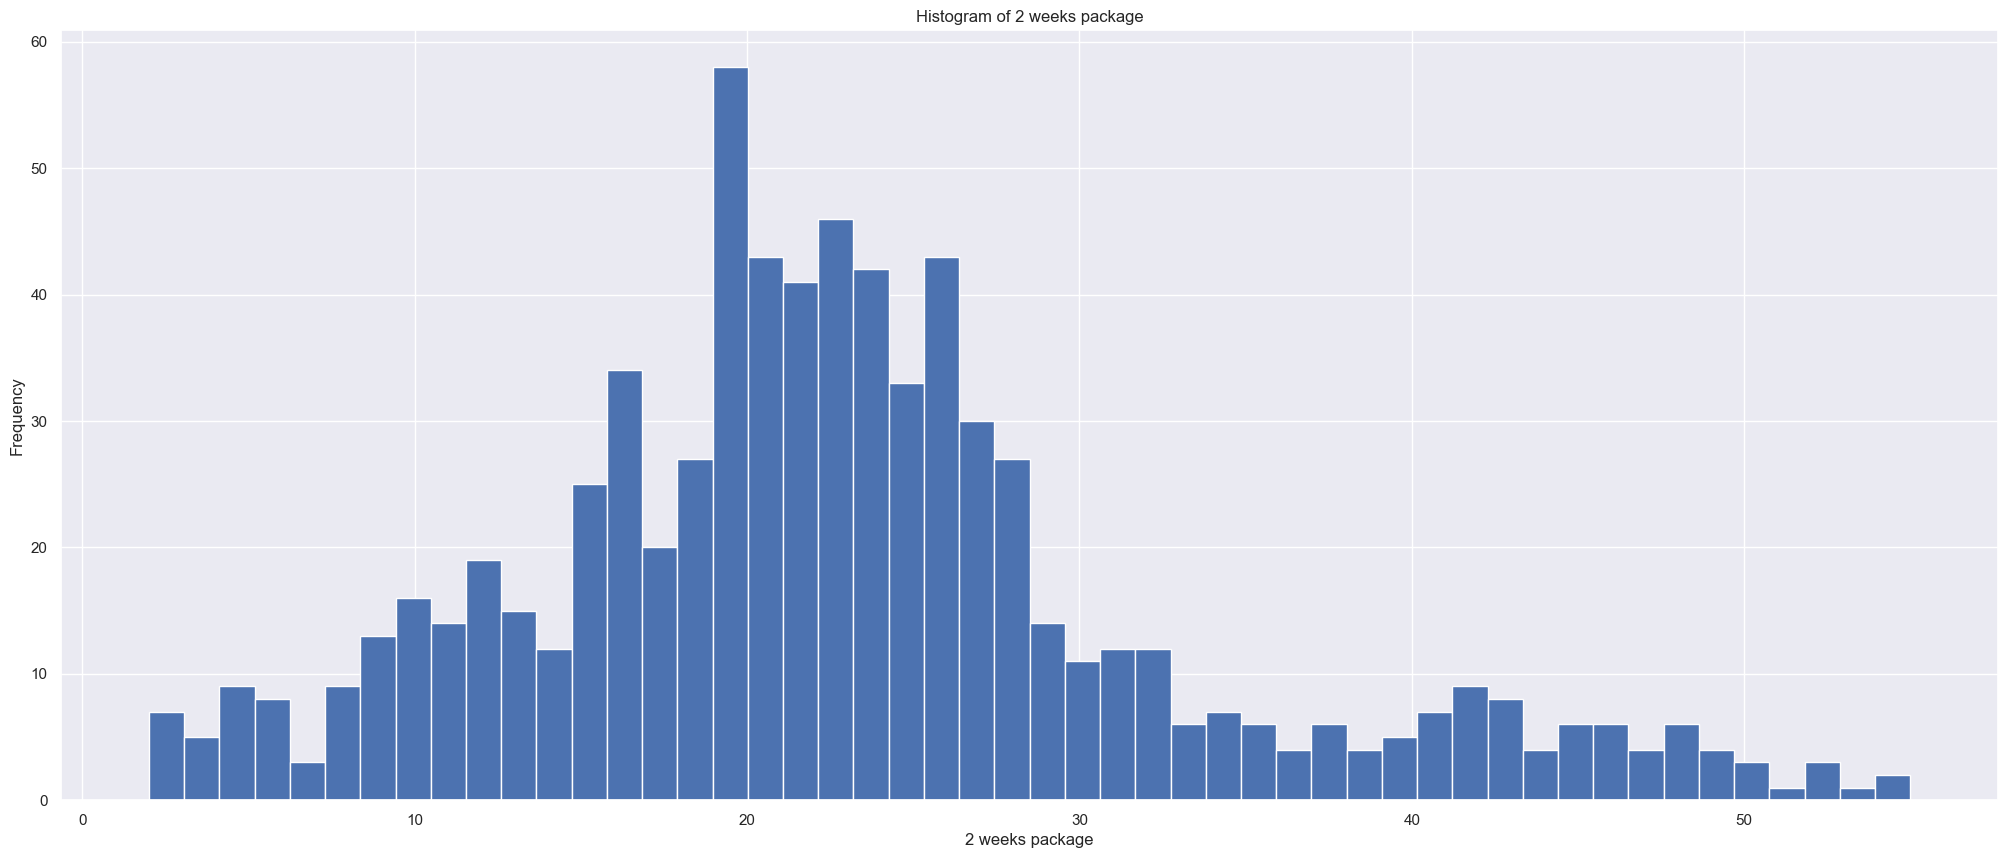

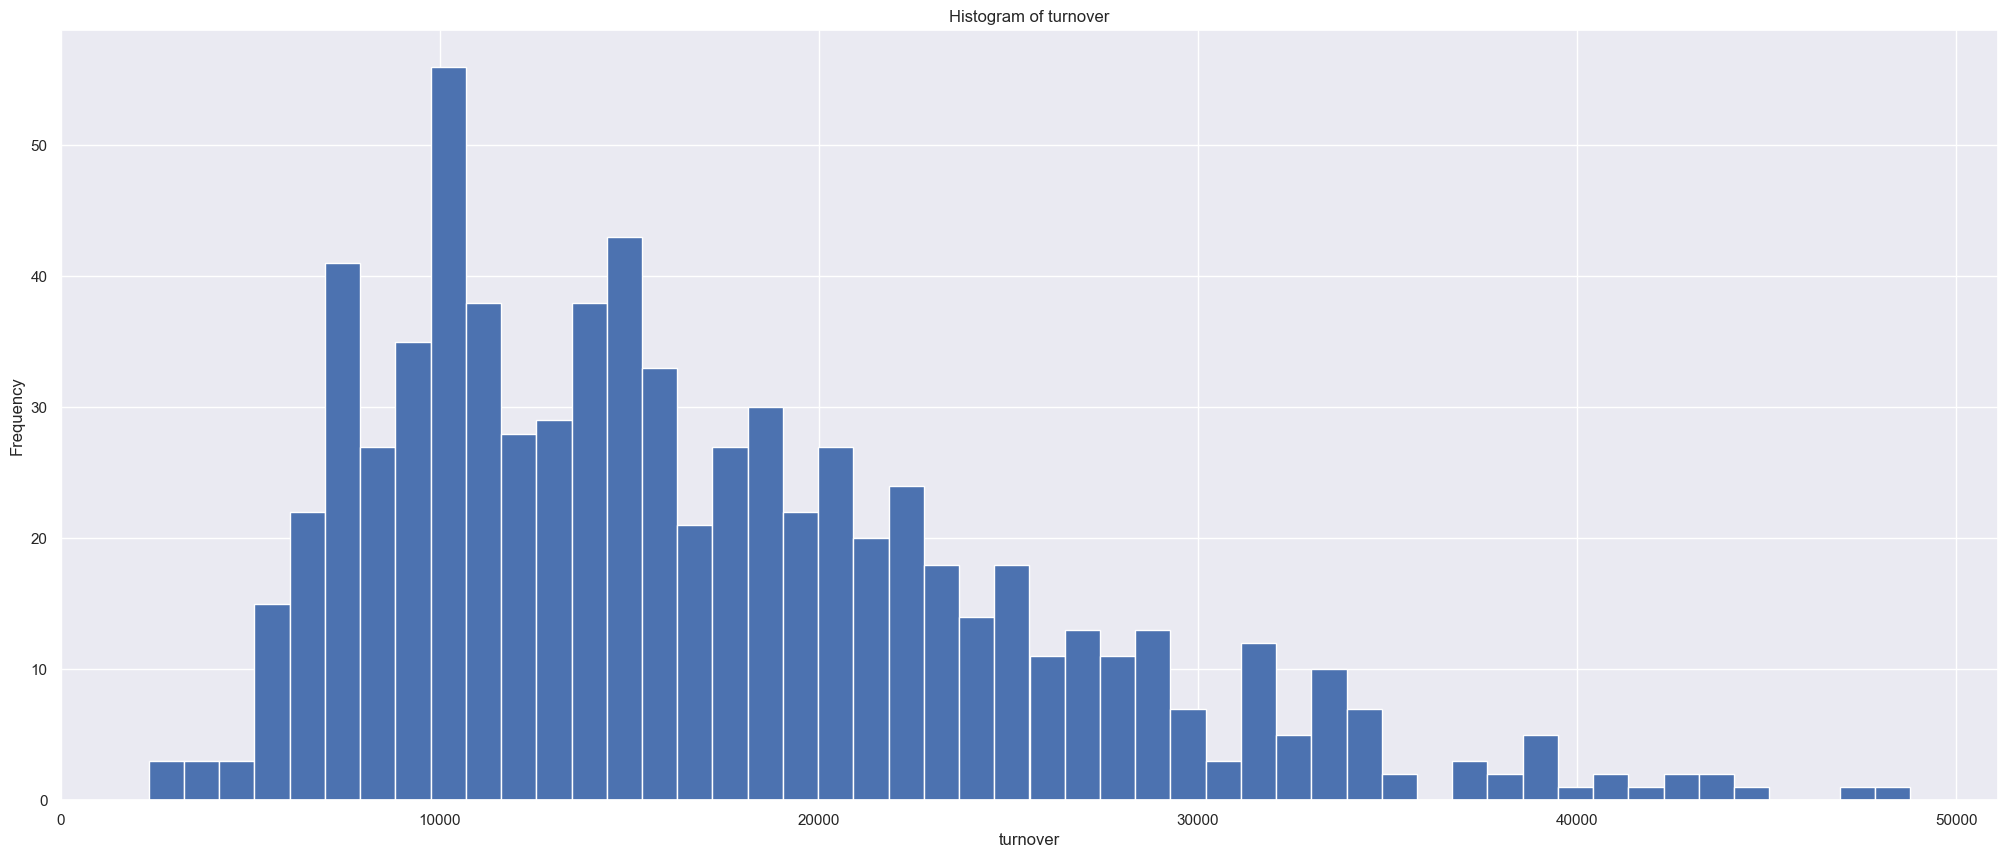

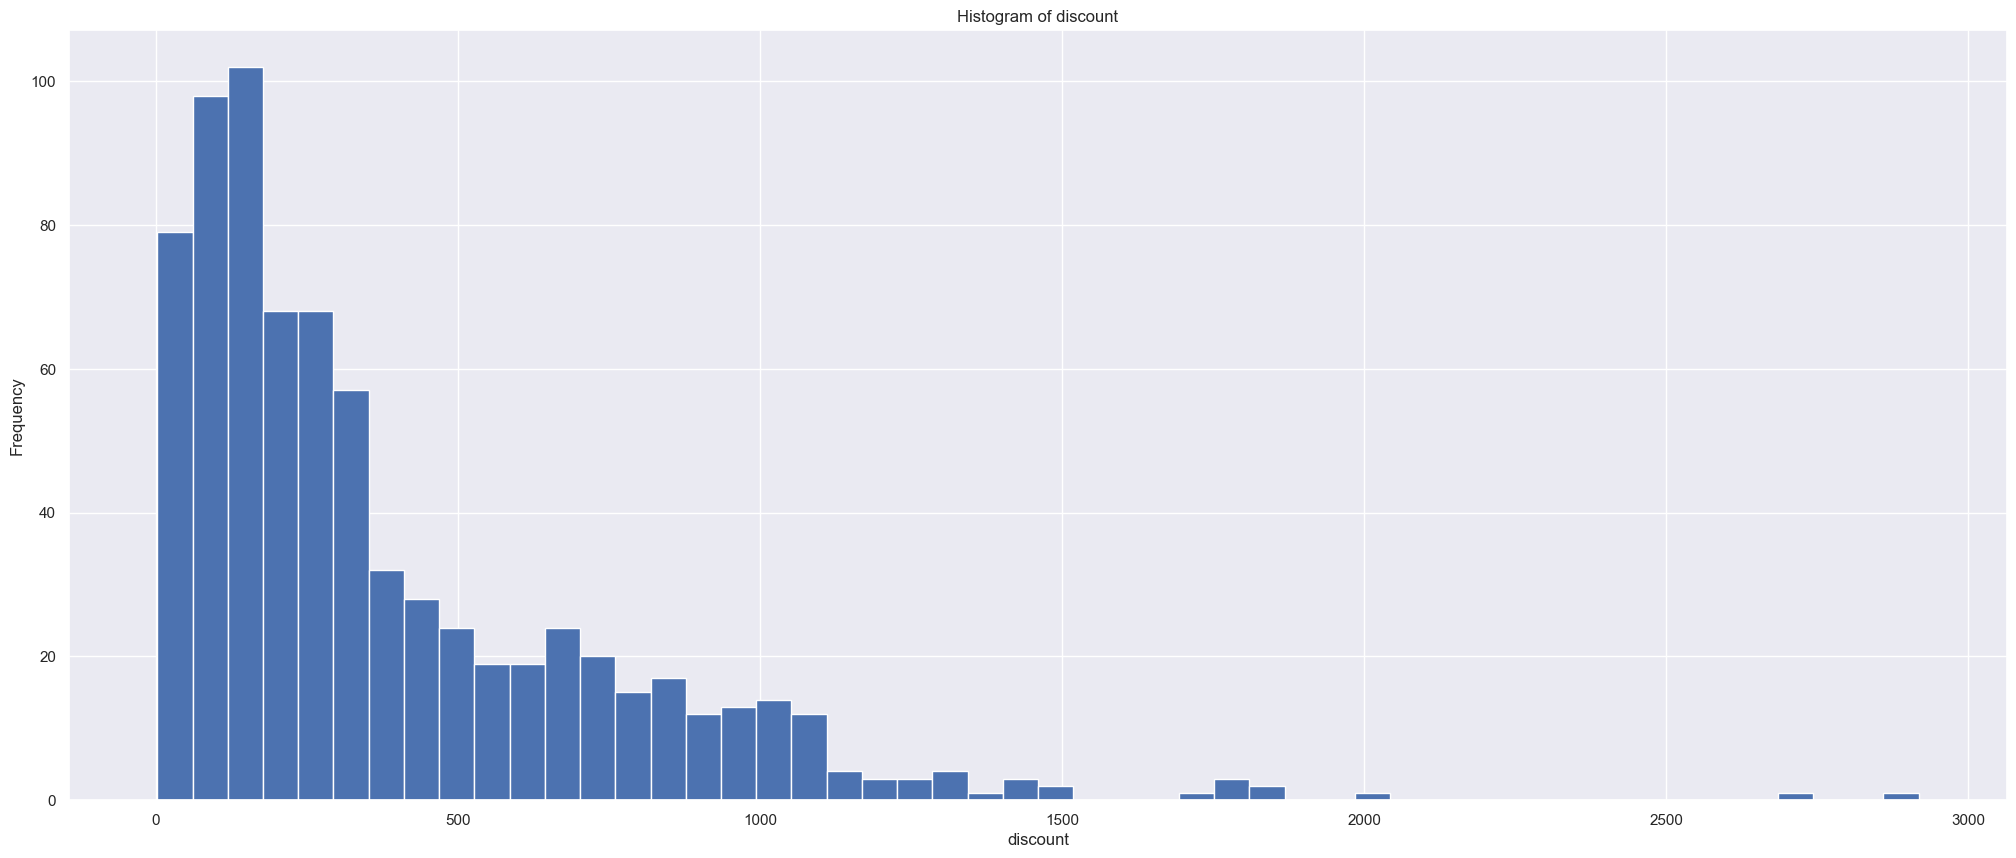

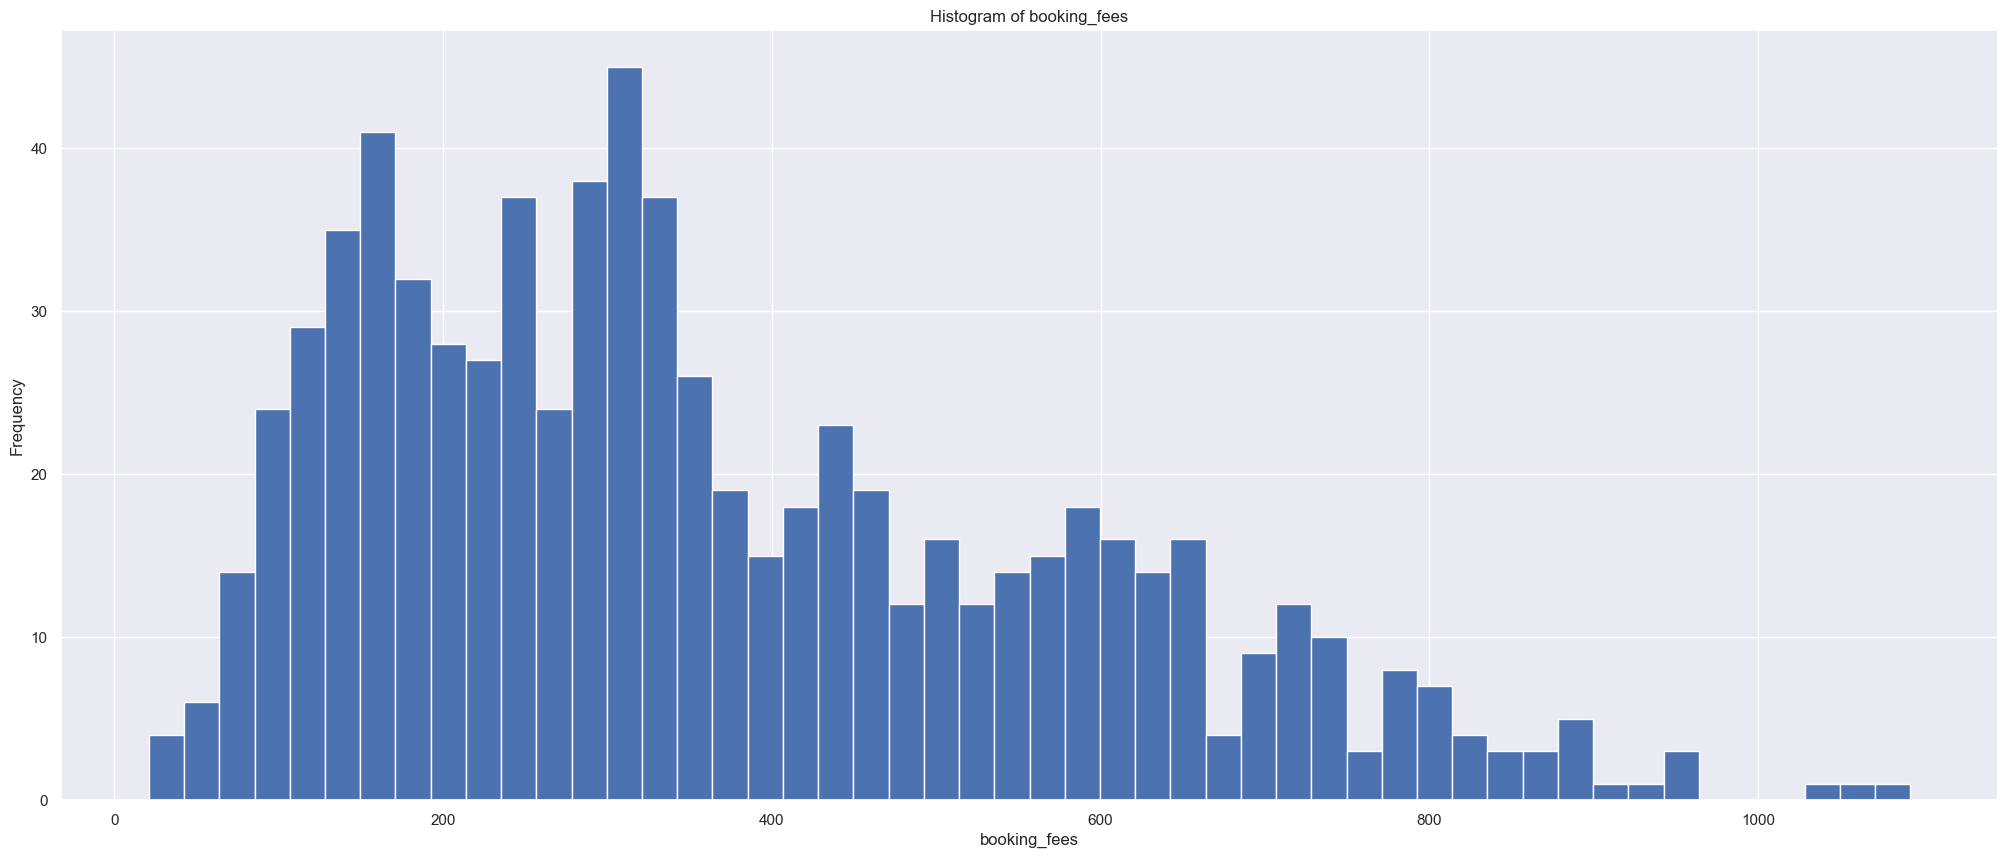

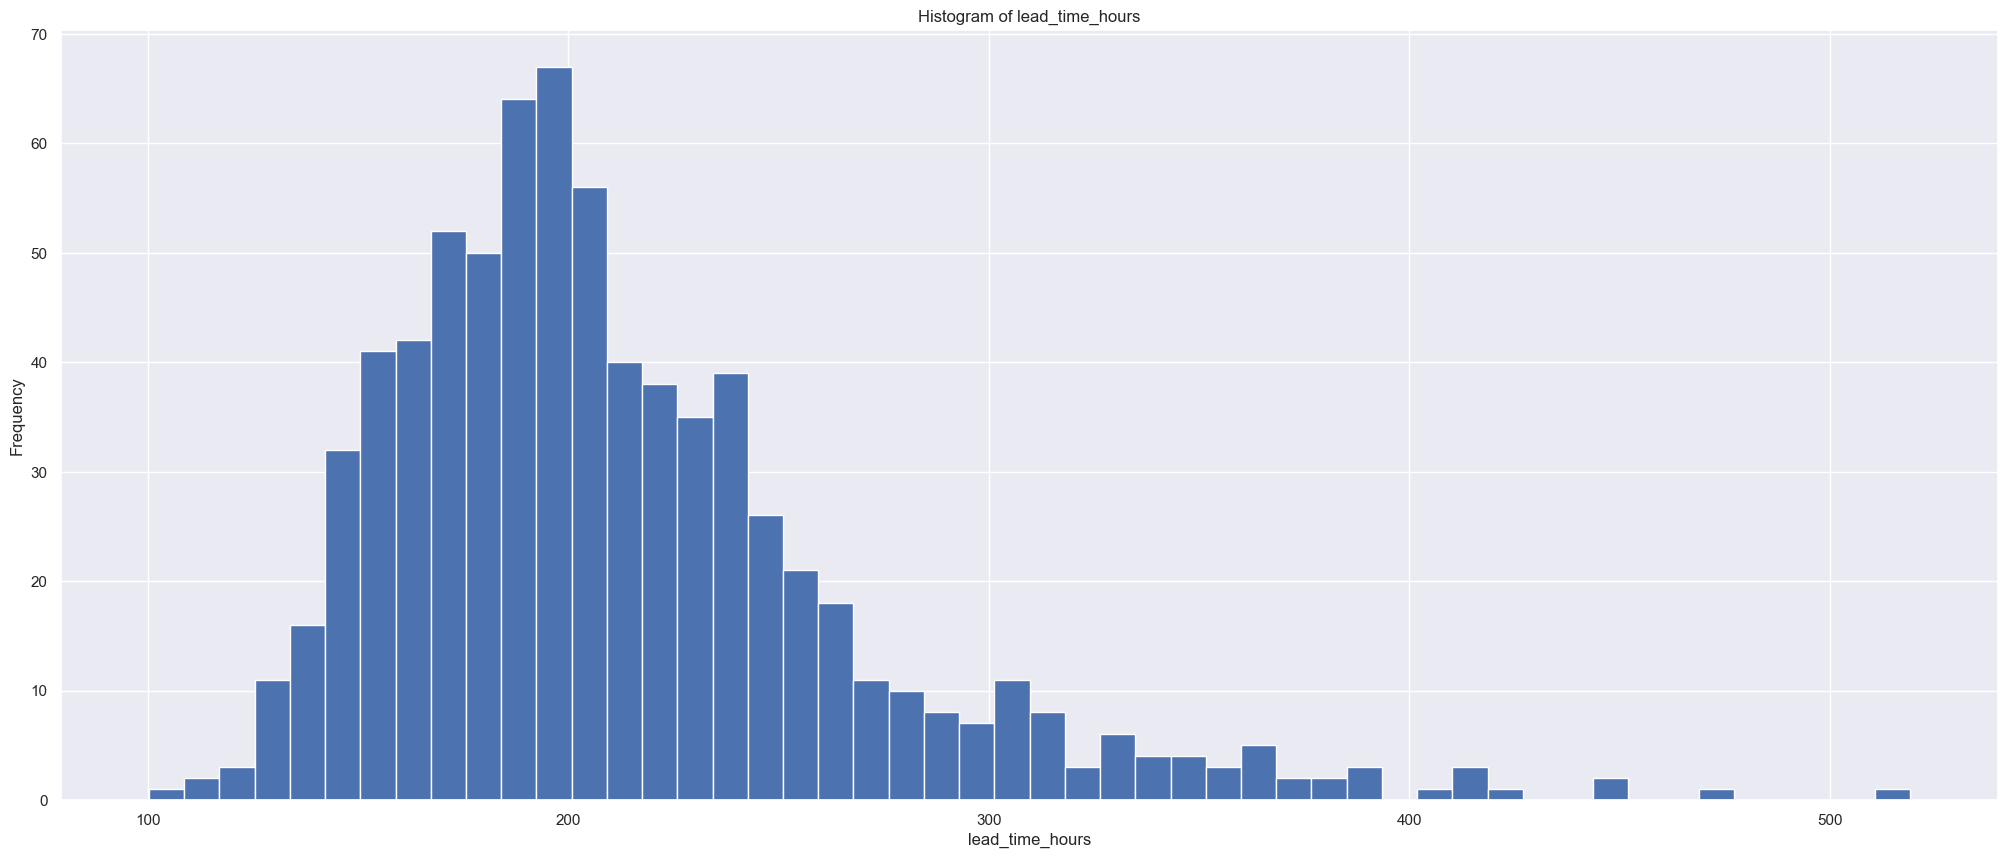

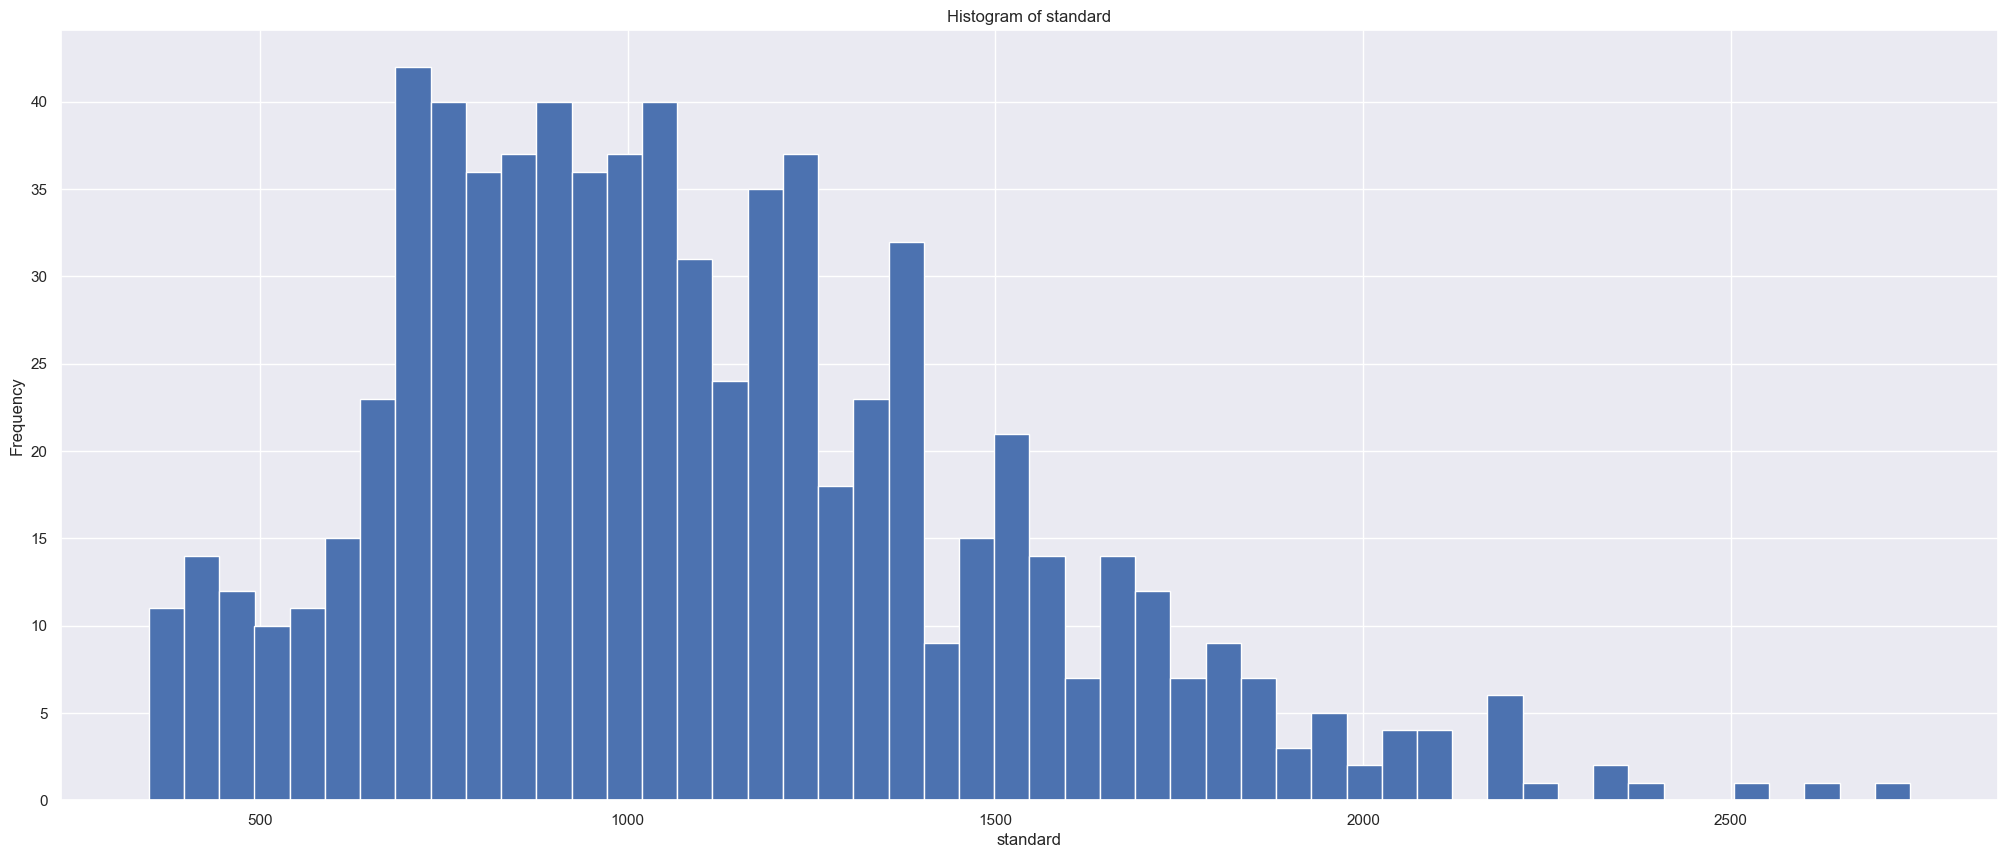

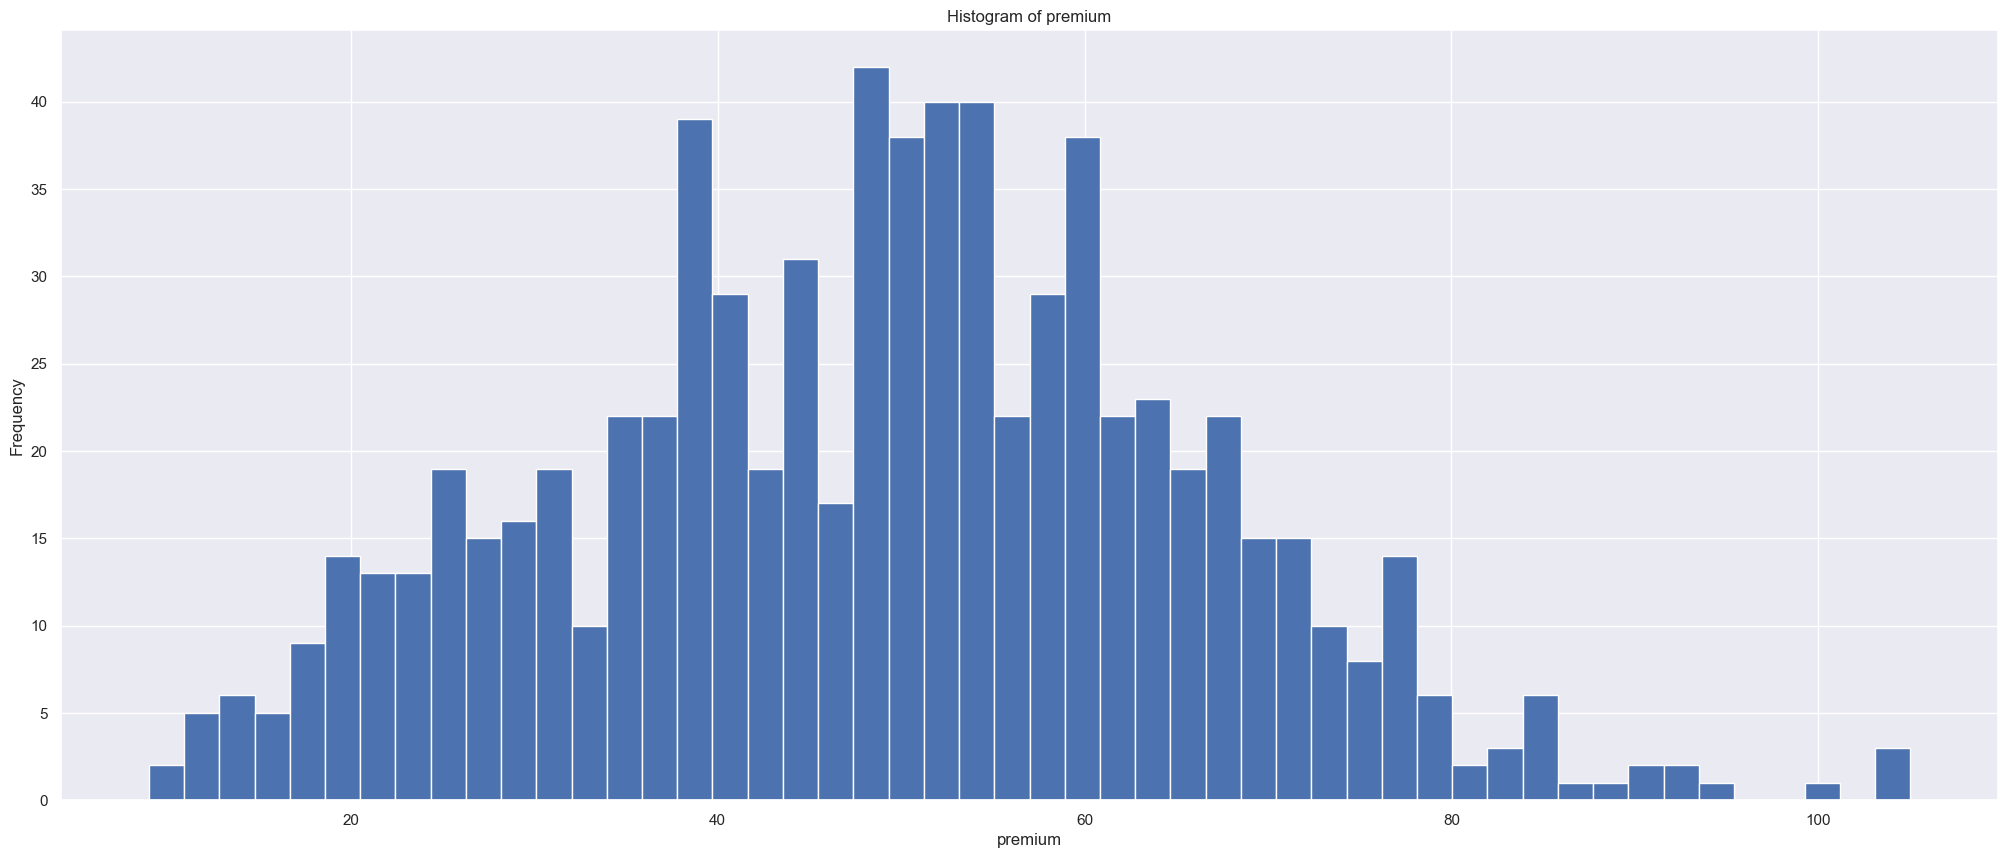

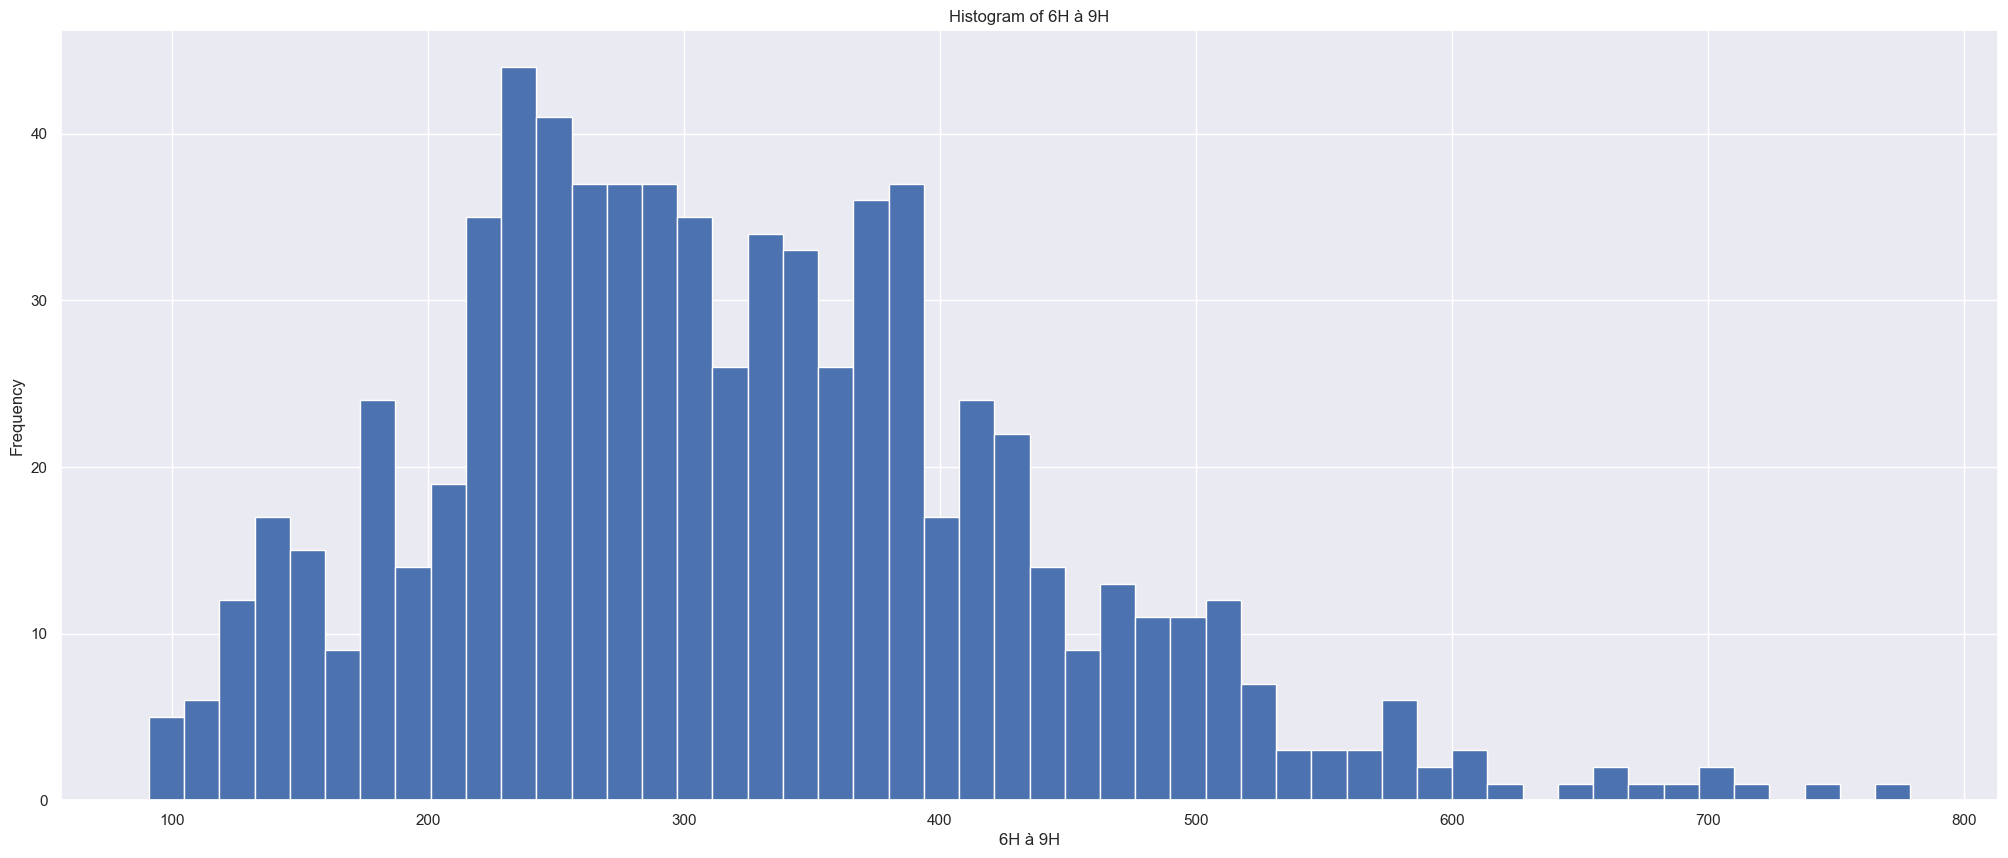

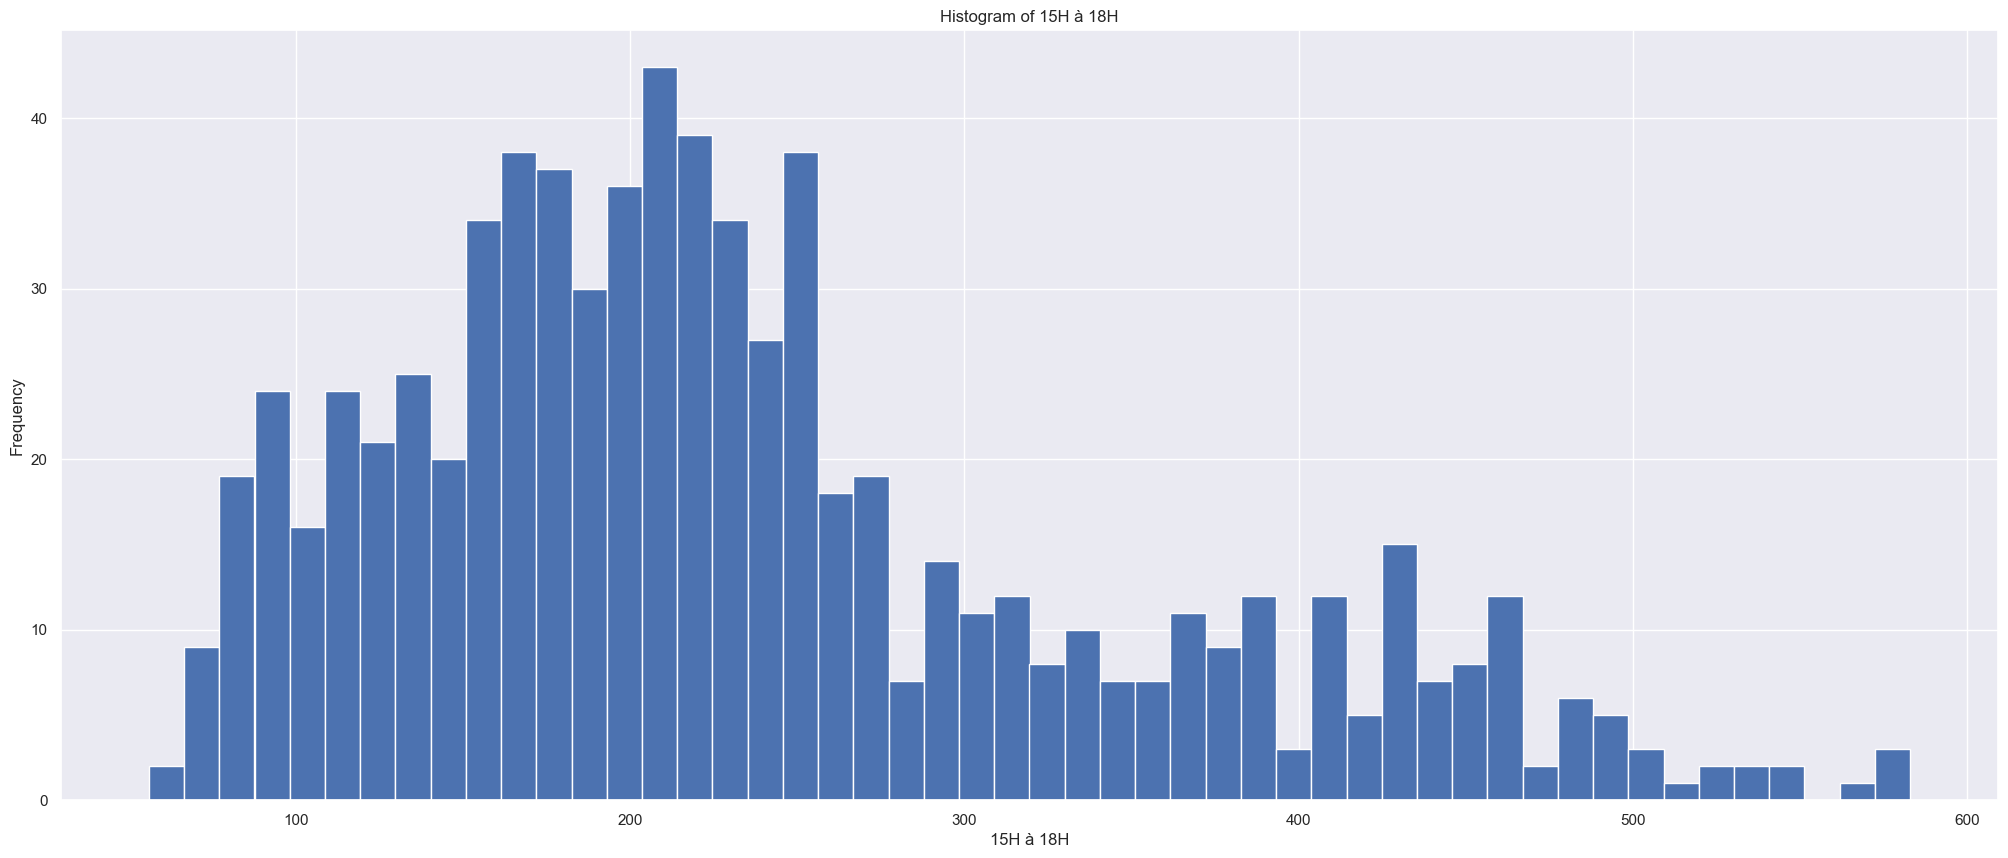

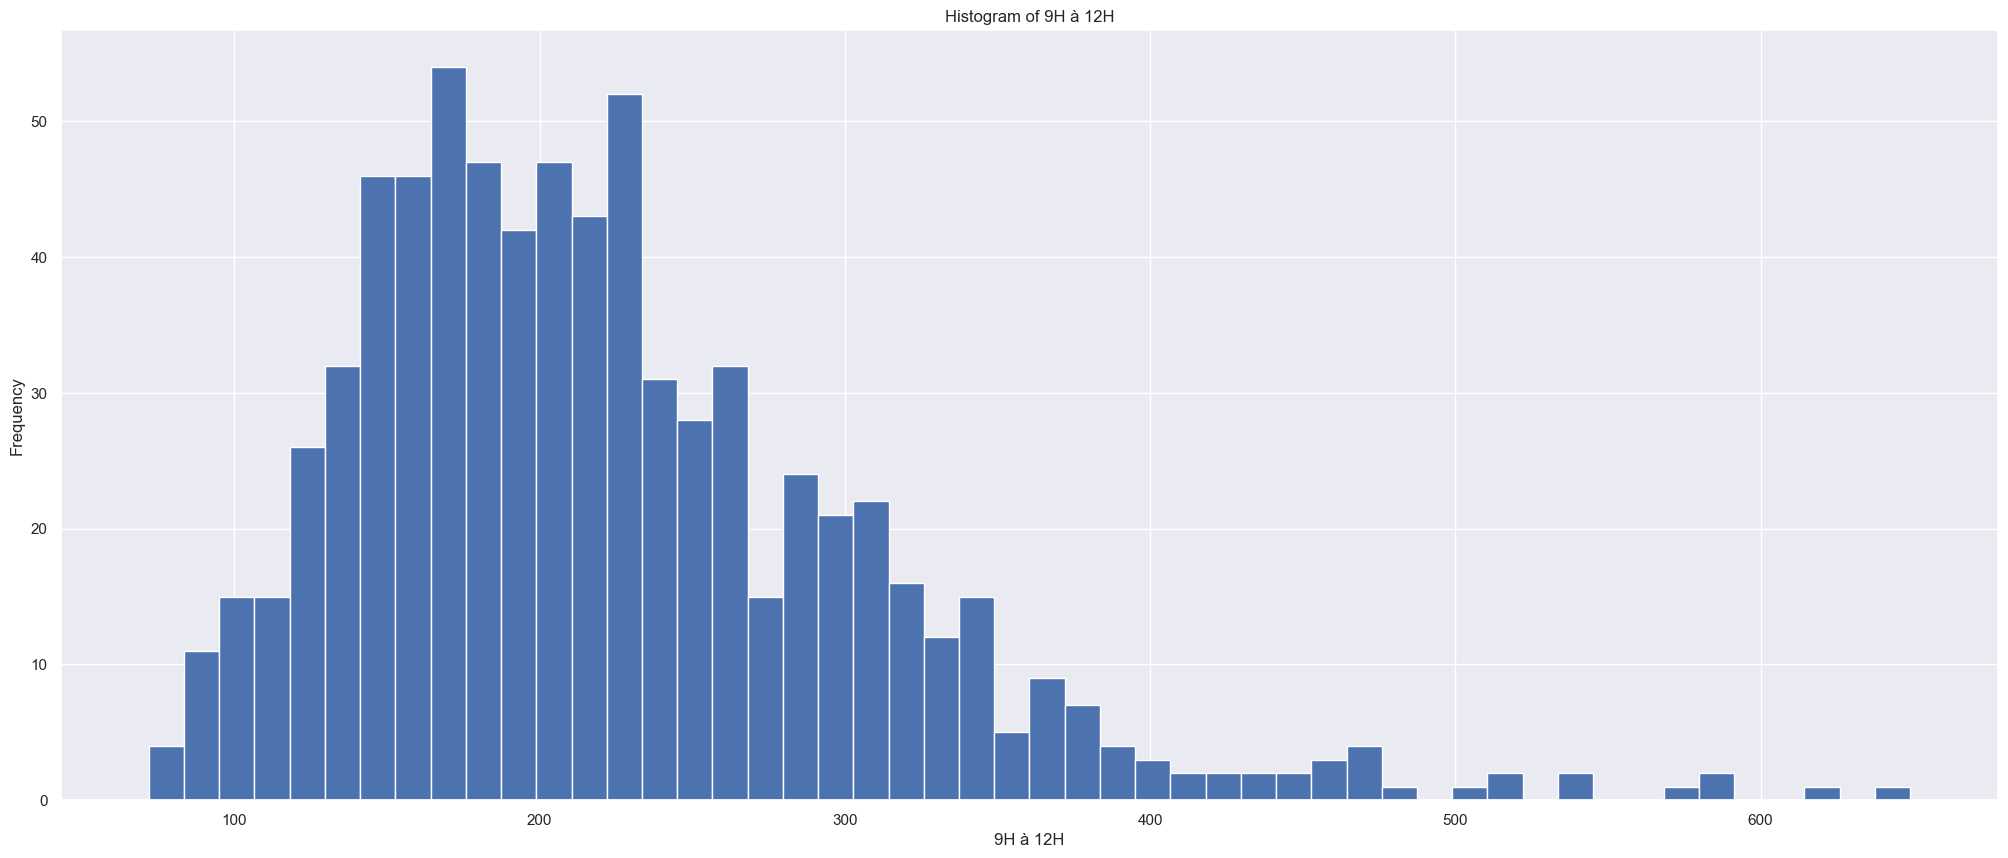

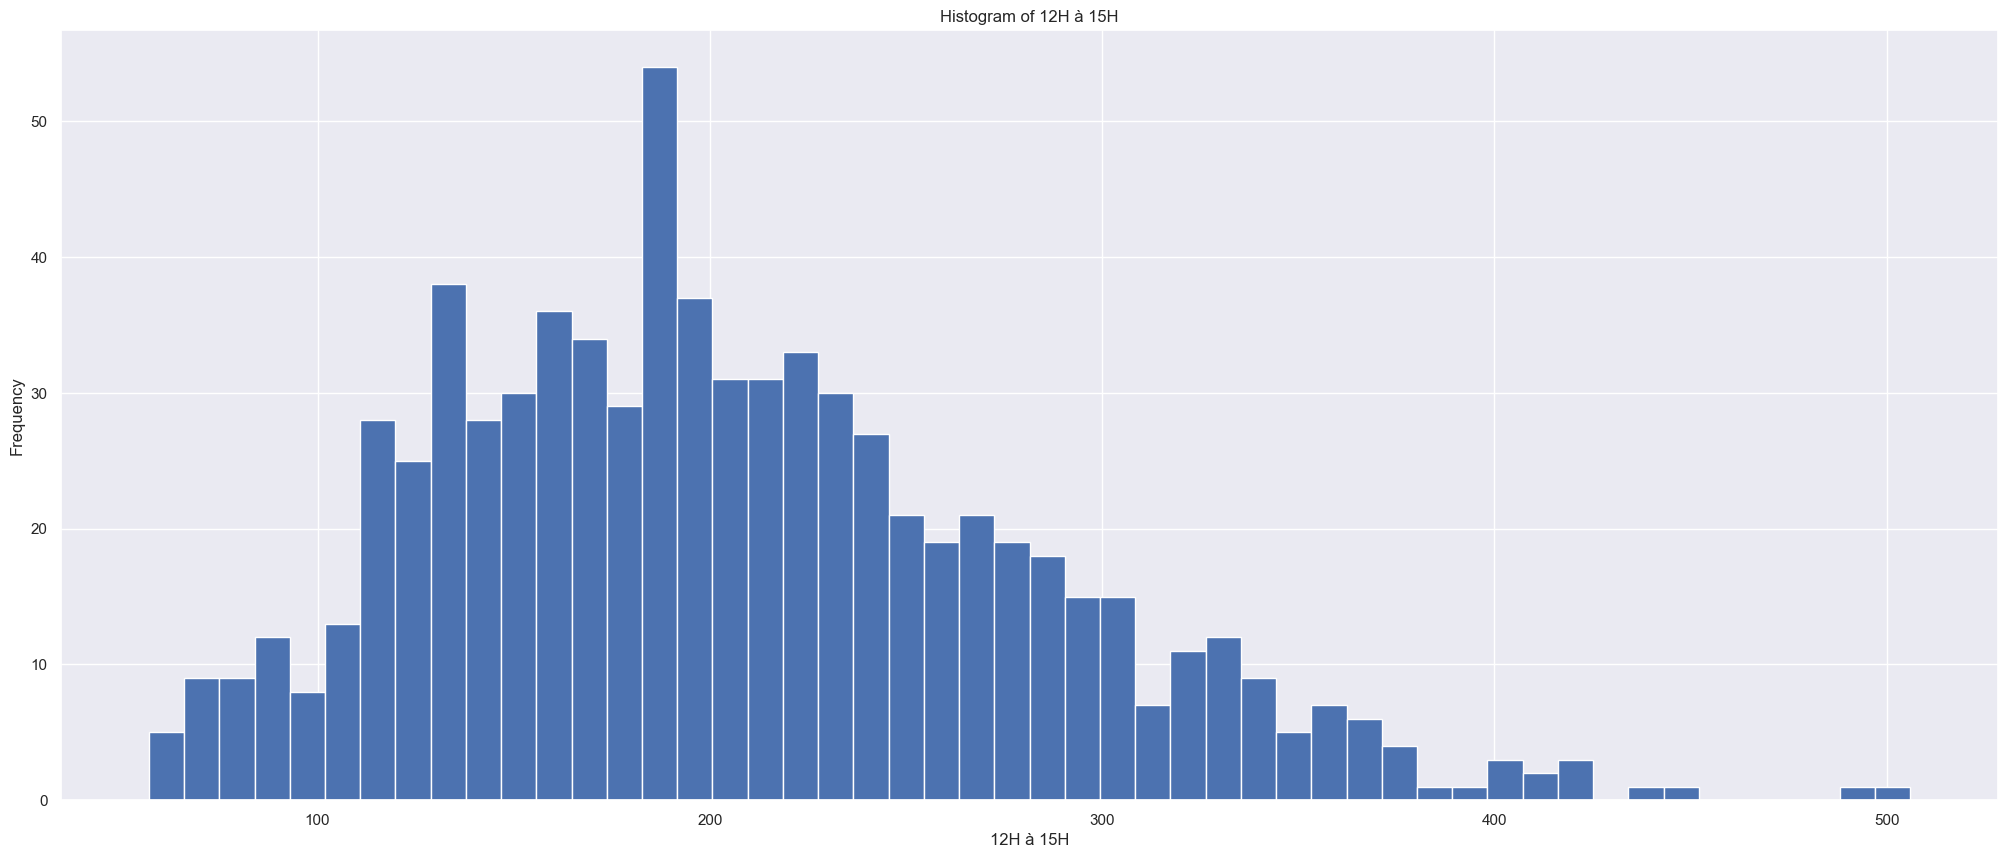

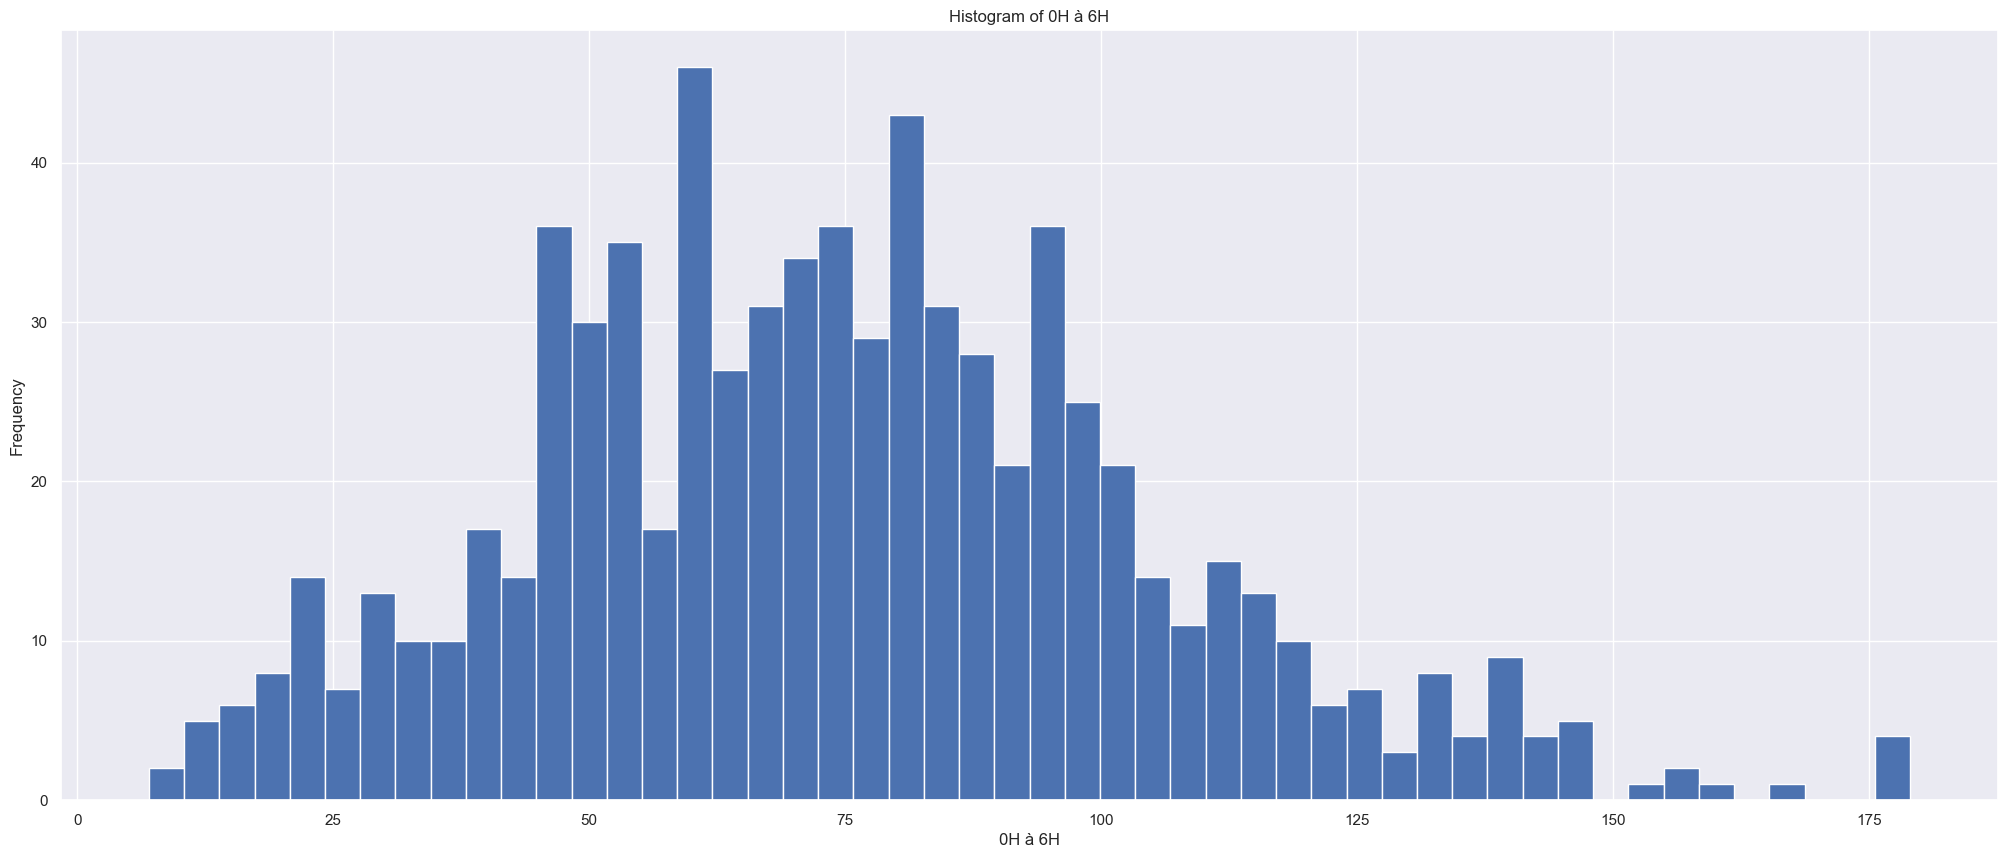

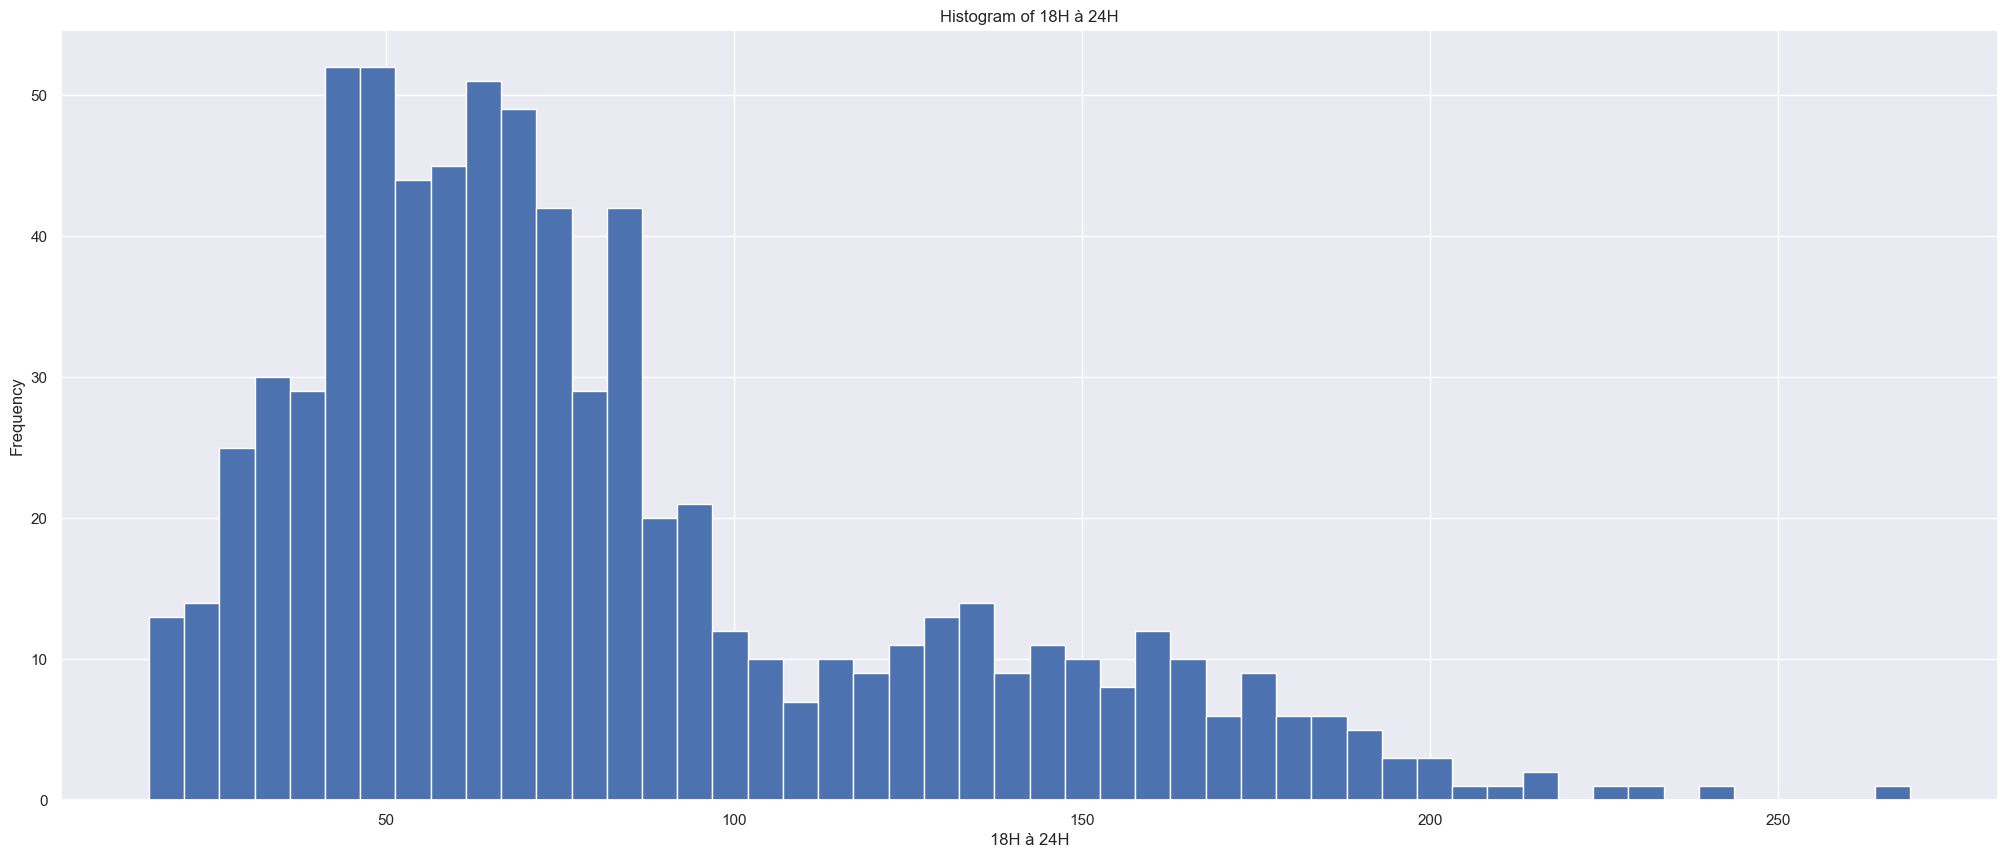

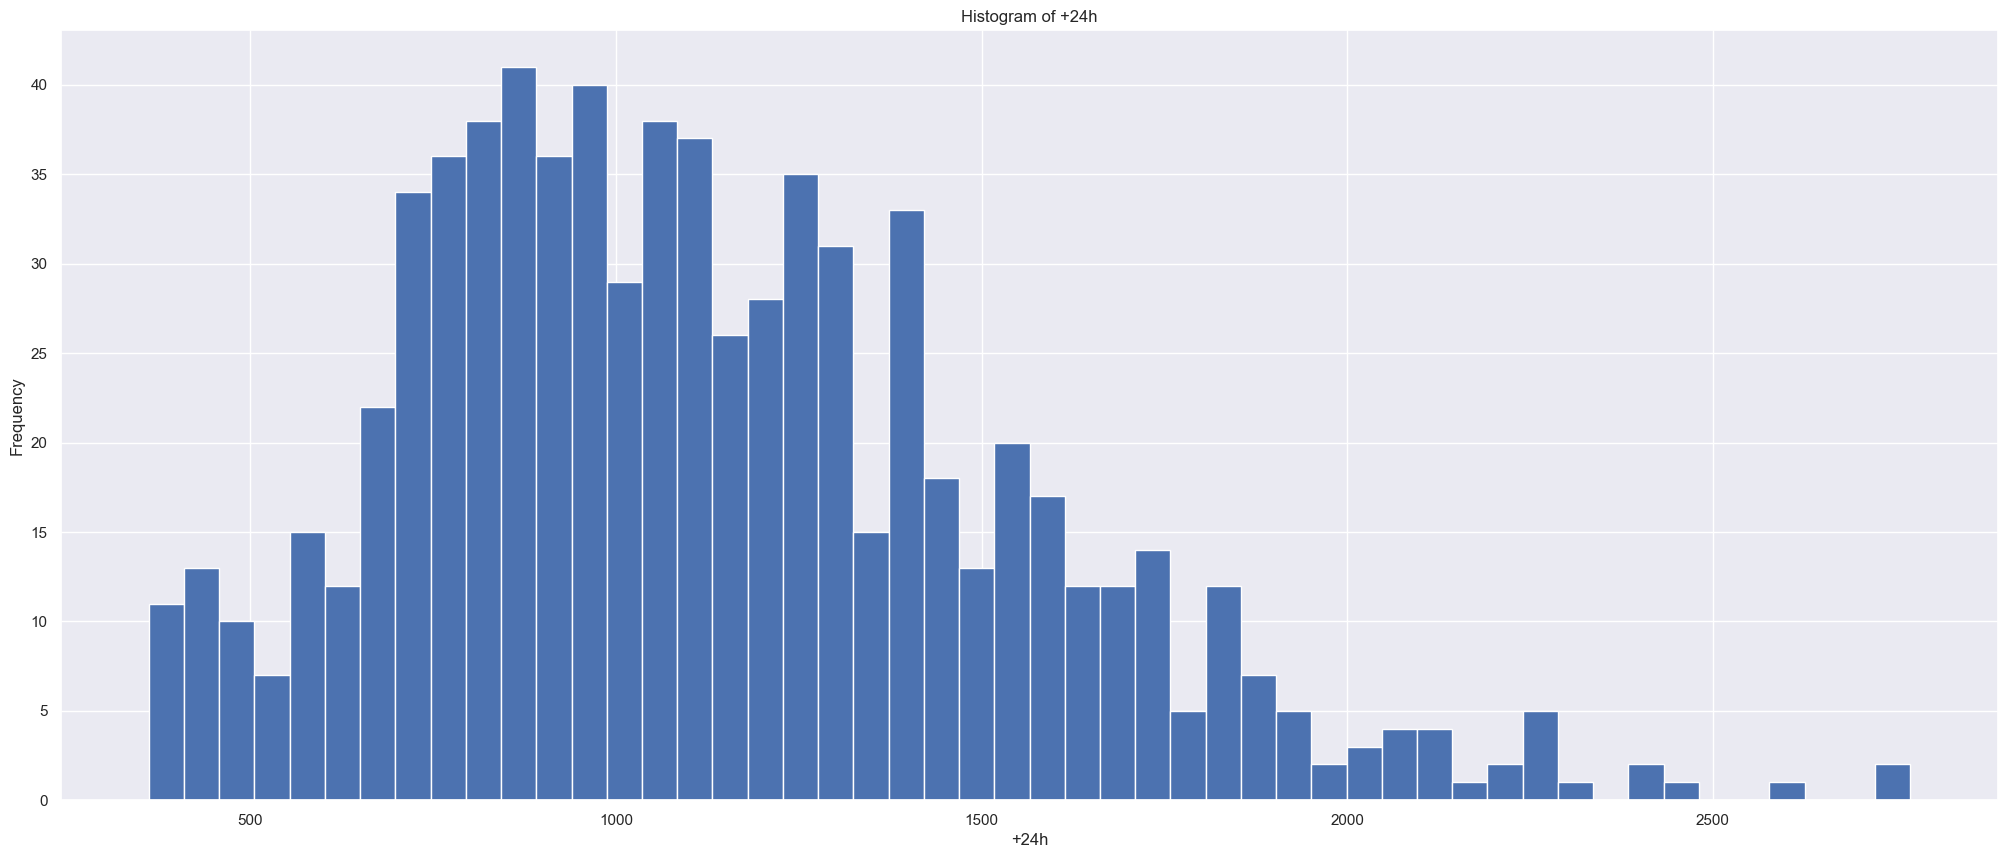

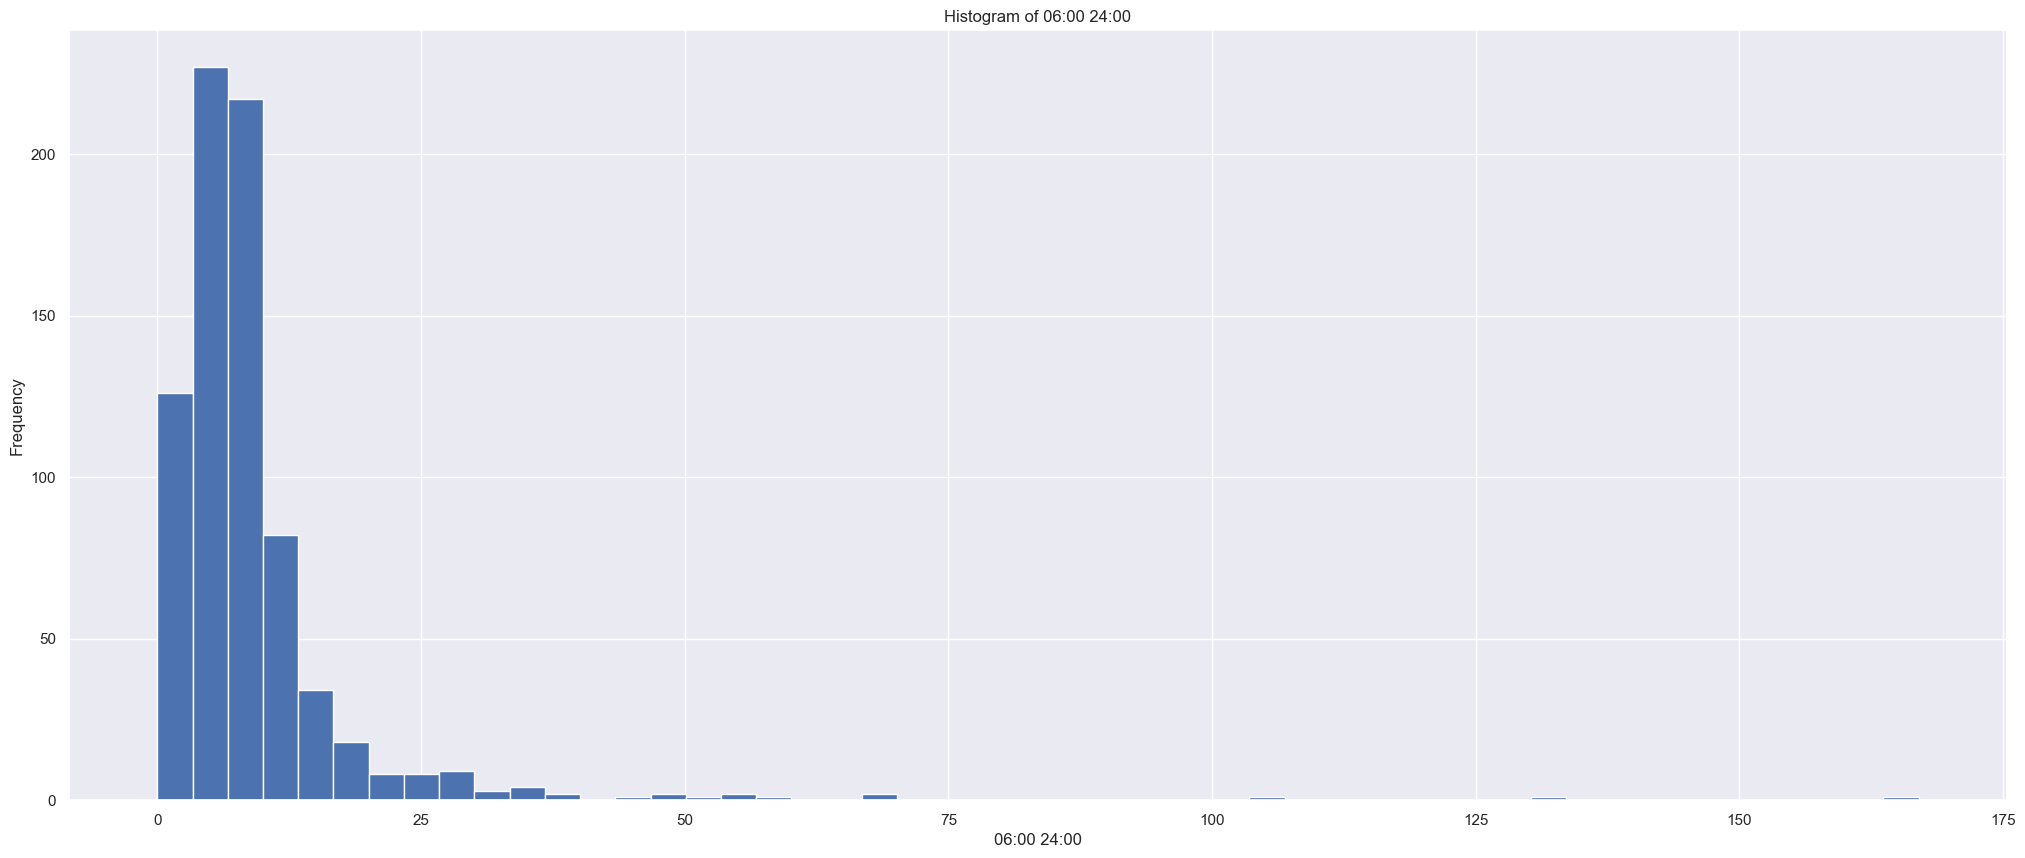

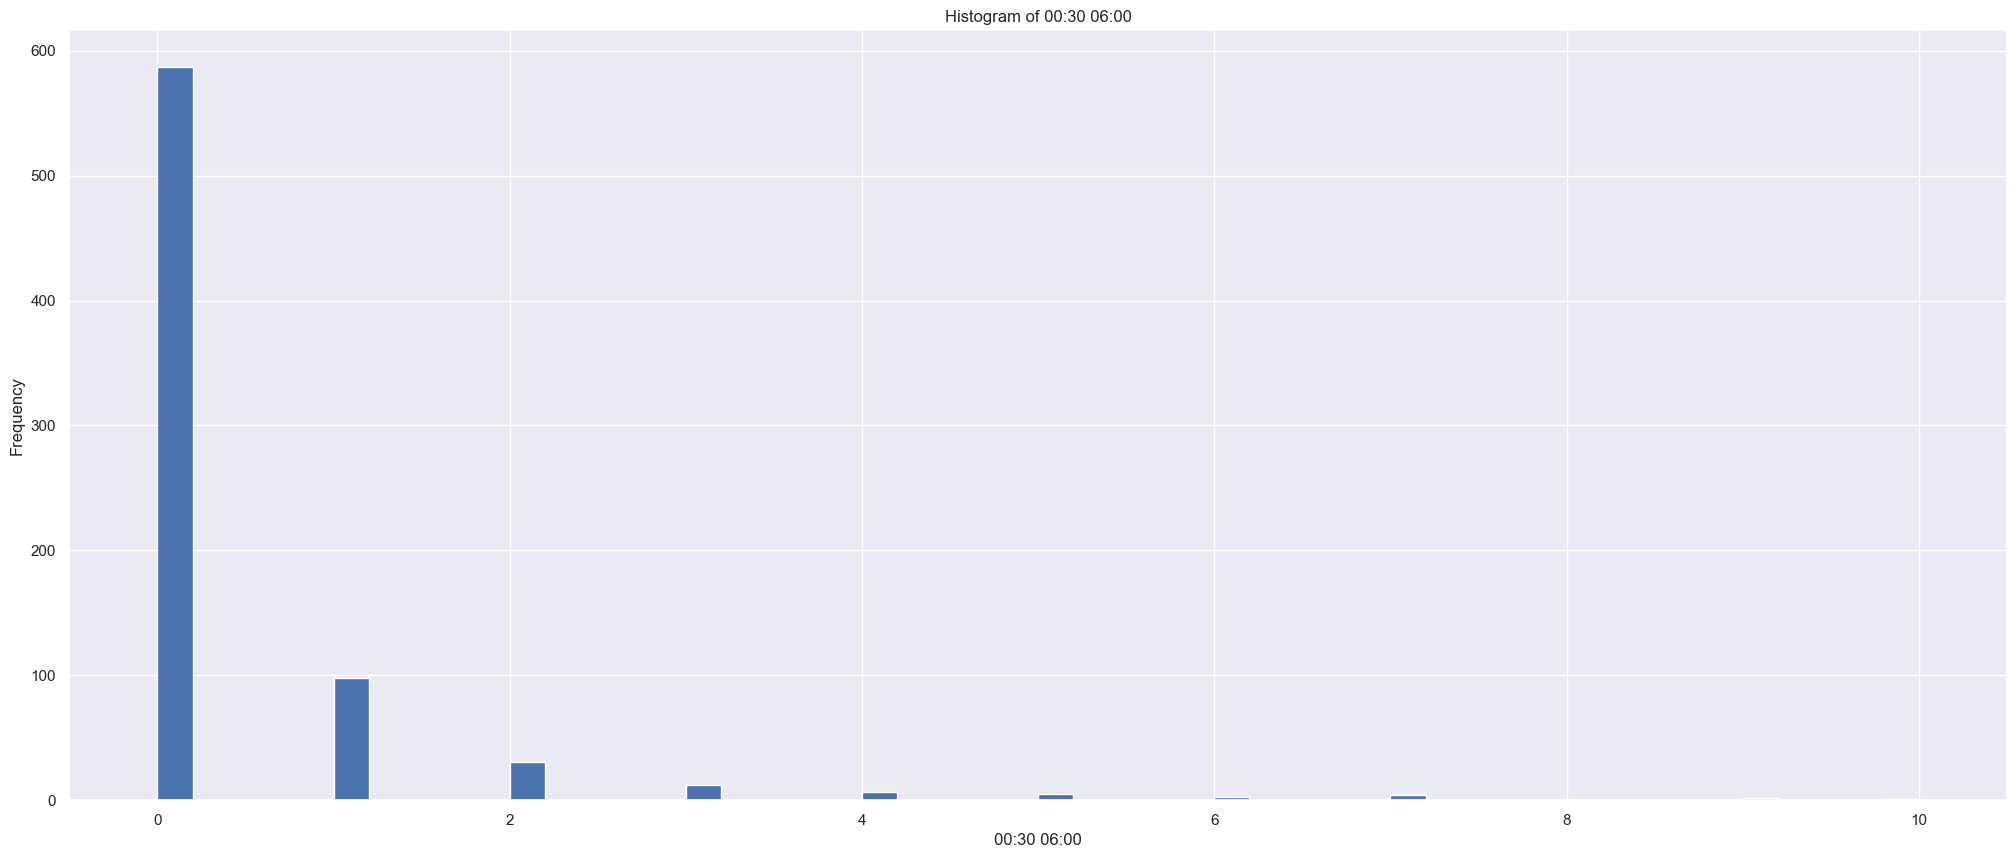

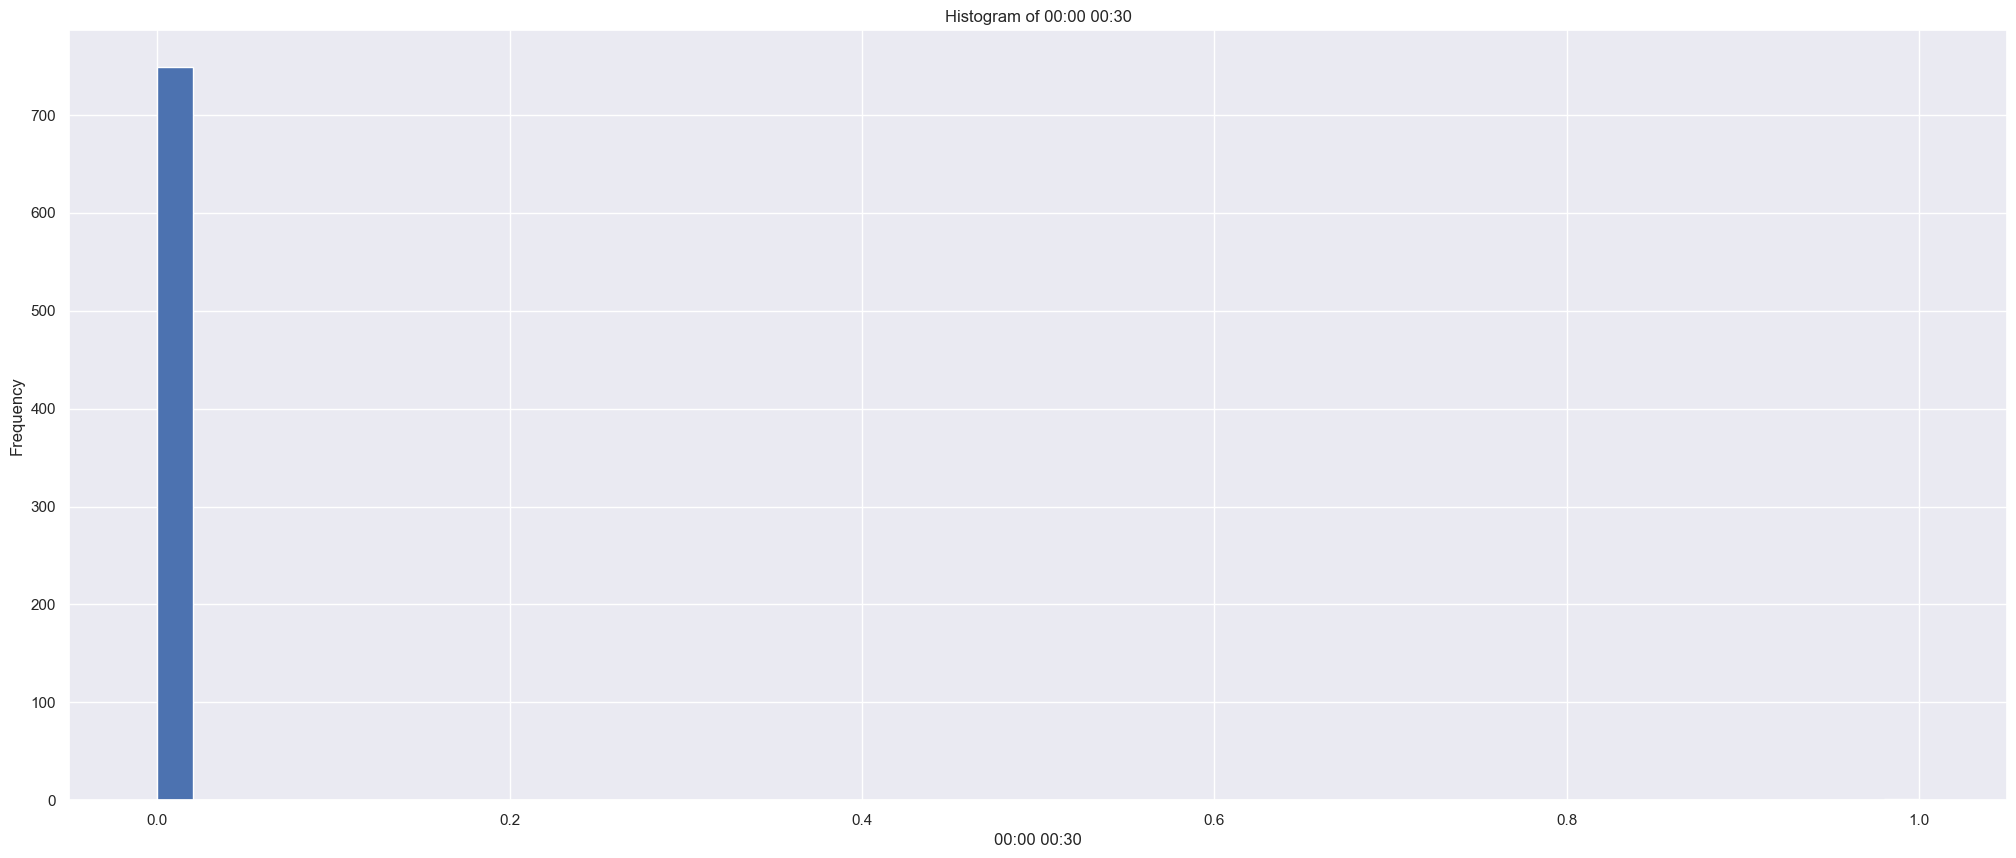

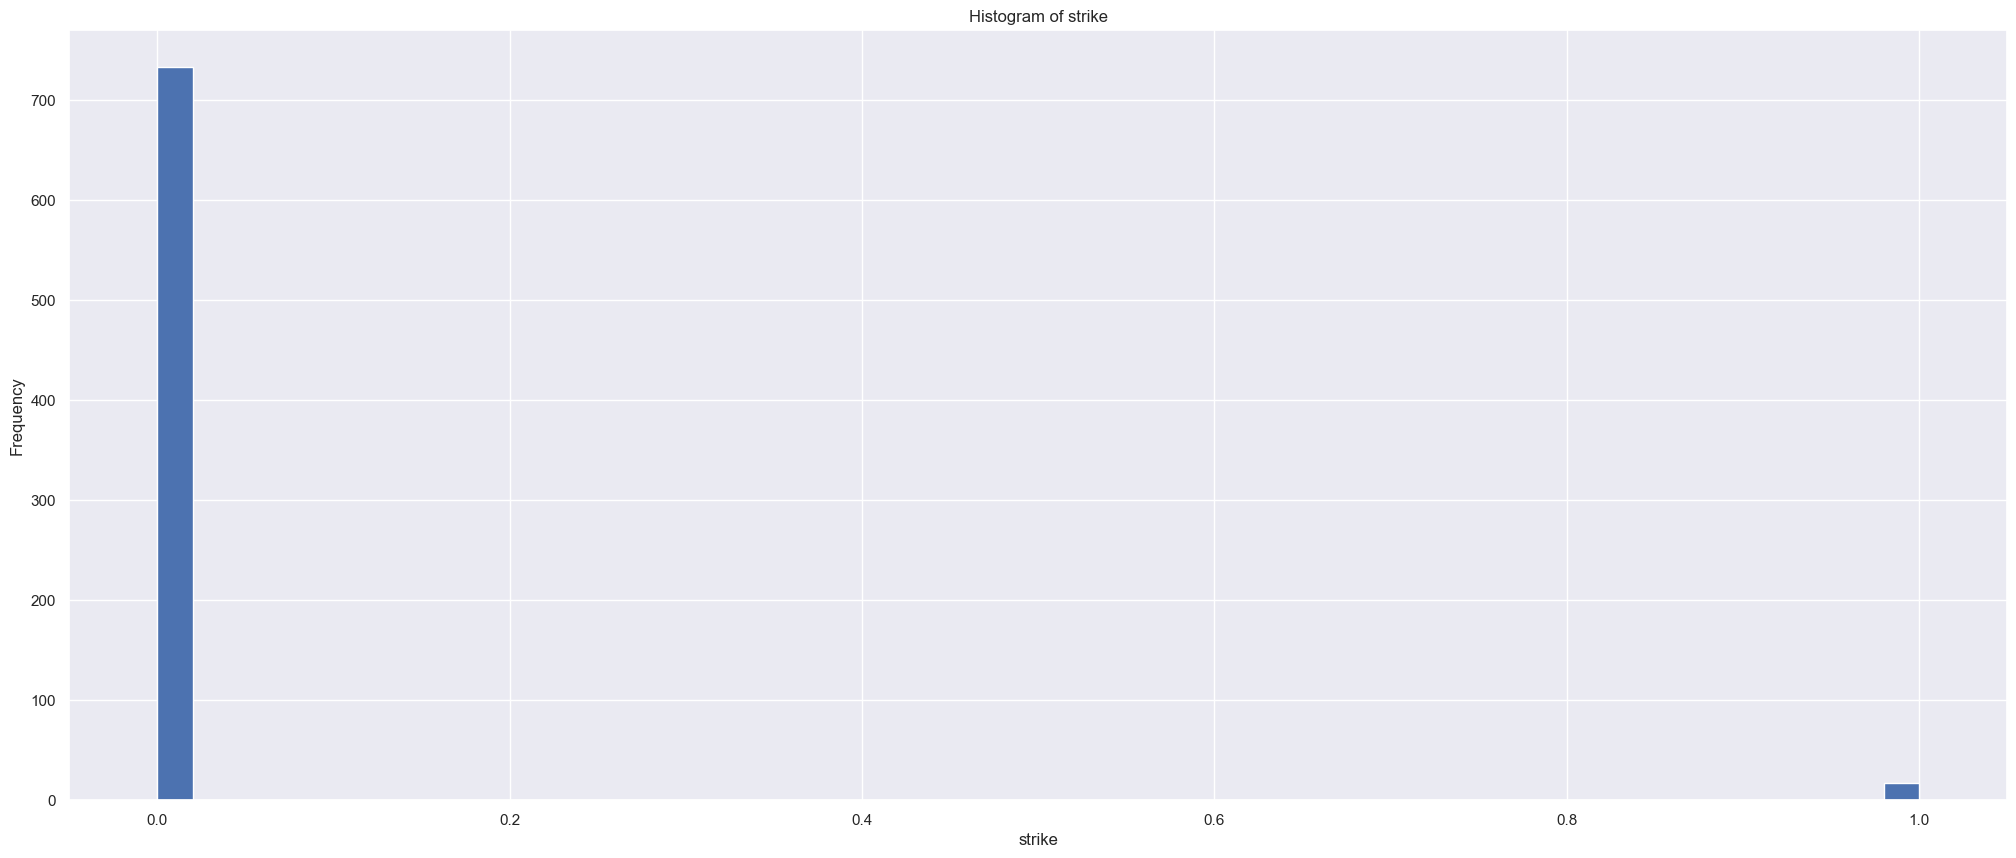

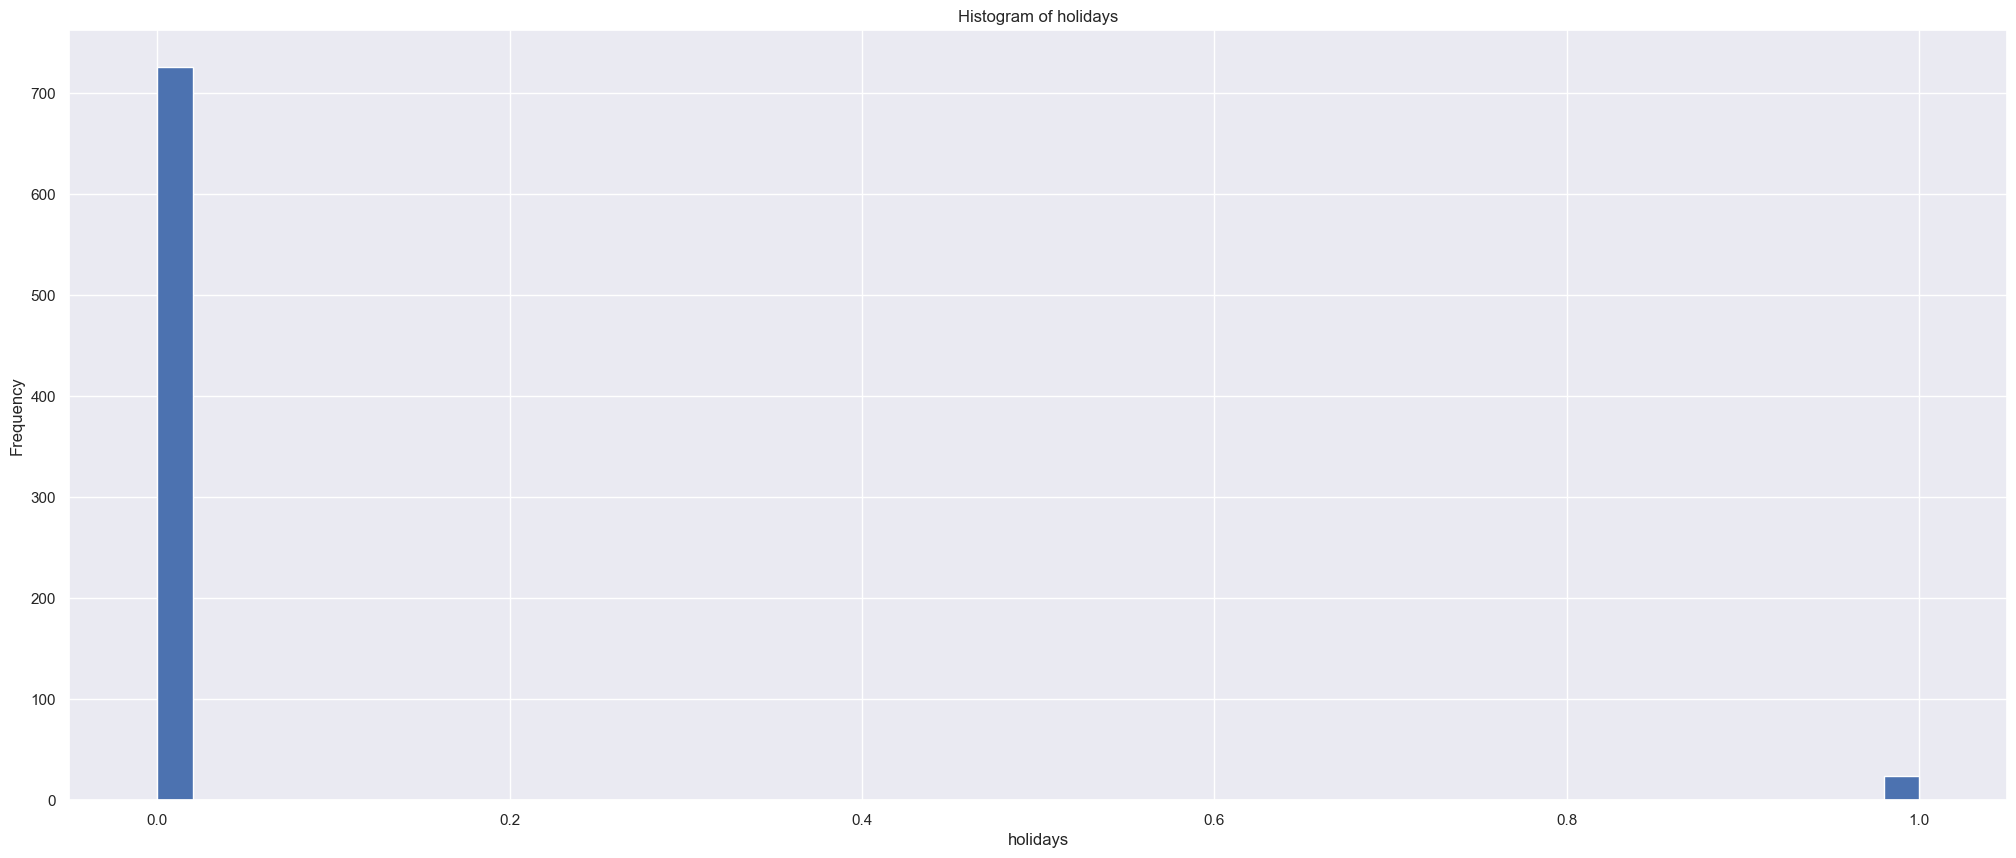

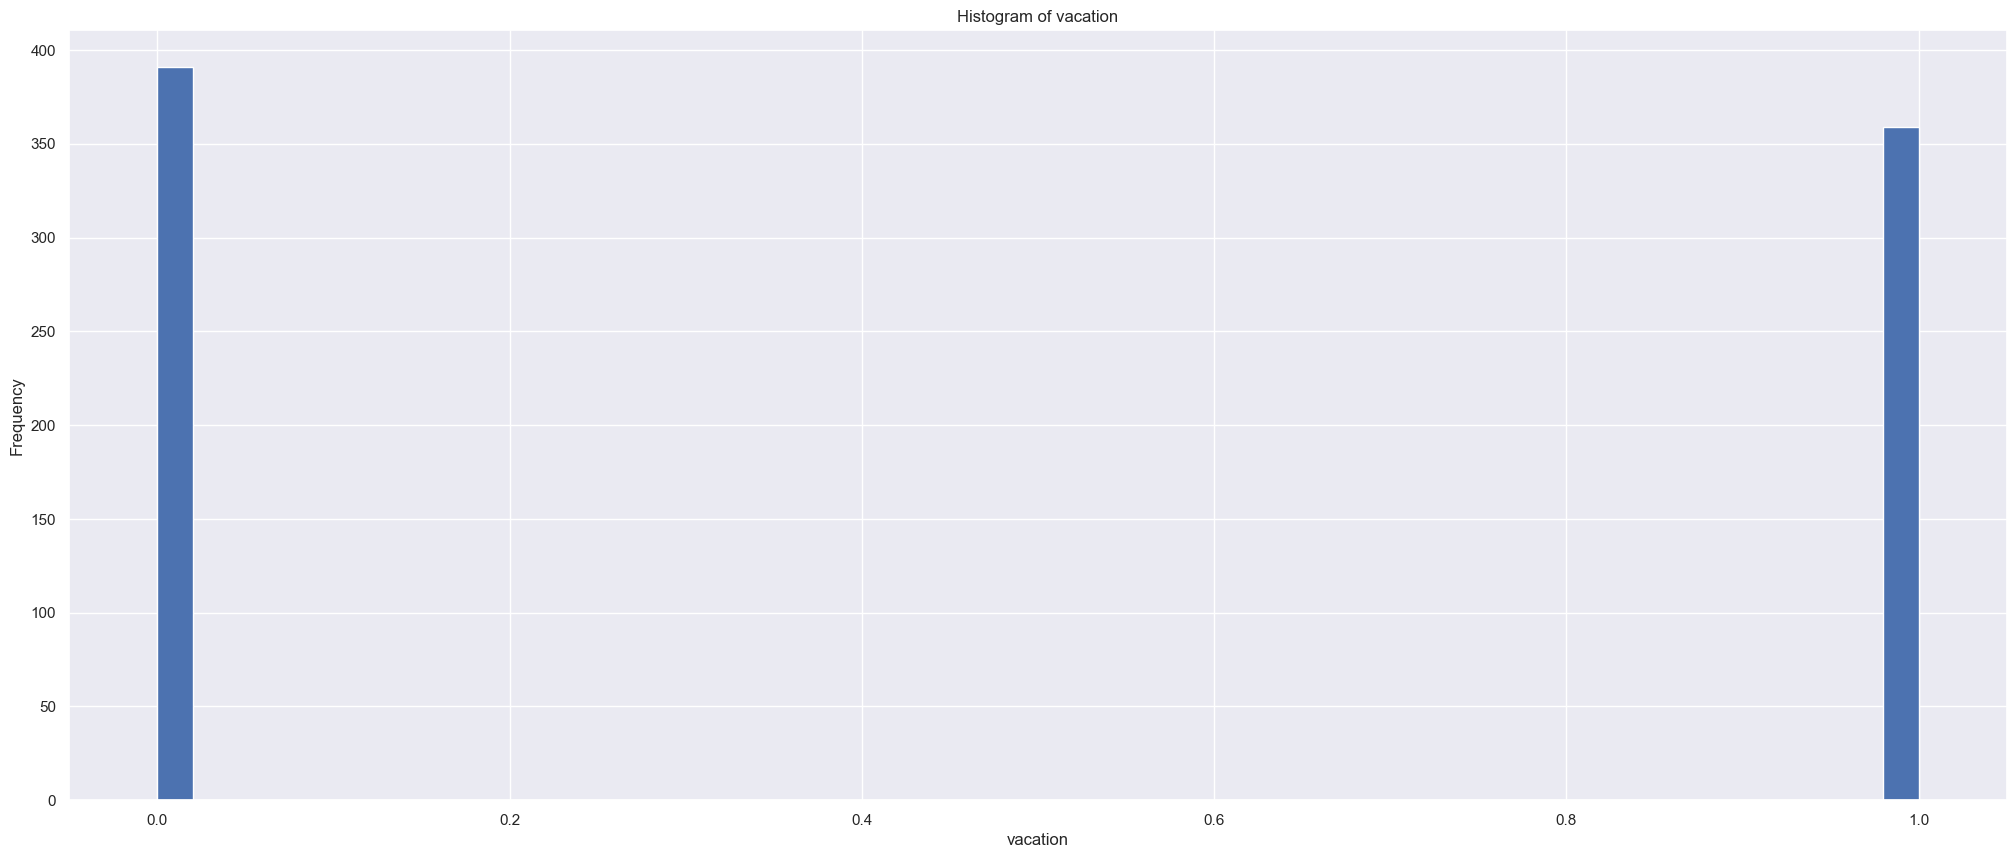

In [98]:
columns = df_for_scaling.columns

extracted_columns = df_for_scaling[columns]
extracted_columns

for column in extracted_columns:
    plt.hist(extracted_columns[column], bins=50)
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column}')
    plt.show()

## Scaling (MinMax Scaler)

In [99]:
columns

Index(['date', 'nb_cars', 'nb_cars_cxl', 'nb_bookings', 'nb_bookings_cxl',
       'hourly rate', 'WE package', '1 week package', '1 month package',
       'other package', '2 weeks package', 'turnover', 'discount',
       'booking_fees', 'lead_time_hours', 'standard', 'premium', '6H à 9H',
       '15H à 18H', '9H à 12H', '12H à 15H', '0H à 6H', '18H à 24H', '+24h',
       '06:00 24:00', '00:30 06:00', '00:00 00:30', 'strike', 'holidays',
       'vacation'],
      dtype='object')

In [100]:
mmscaler = MinMaxScaler()

In [101]:
columns_to_transform = ['nb_cars', 'nb_cars_cxl', 'nb_bookings', 'nb_bookings_cxl',
       'hourly rate', 'WE package', '1 week package', '1 month package',
       'other package', '2 weeks package', 'turnover', 'discount',
       'booking_fees', 'lead_time_hours', 'standard', 'premium', '6H à 9H',
       '15H à 18H', '9H à 12H', '12H à 15H', '0H à 6H', '18H à 24H', '+24h',
       '06:00 24:00', '00:30 06:00', '00:00 00:30']

In [102]:
df_minmax_scaled = df_for_scaling

In [103]:
df_minmax_scaled[columns_to_transform] = mmscaler.fit_transform(df_for_scaling[columns_to_transform])

In [104]:
df_minmax_scaled.head()

,date,nb_cars,nb_cars_cxl,nb_bookings,nb_bookings_cxl,hourly rate,WE package,1 week package,1 month package,other package,...,12H à 15H,0H à 6H,18H à 24H,+24h,06:00 24:00,00:30 06:00,00:00 00:30,strike,holidays,vacation
0,2021-06-01,0.001610,0.006878,0.099243,0.017857,0.060280,0.009115,0.035322,0.053191,0.151515,...,0.004454,0.087209,0.007905,0.001660,0.017964,0.0,0.0,0,0,0
1,2021-06-02,0.012480,0.012380,0.096720,0.001984,0.108719,0.000651,0.031397,0.060284,0.090909,...,0.024499,0.098837,0.007905,0.014114,0.000000,0.0,0.0,0,0,0
2,2021-06-03,0.025765,0.001376,0.097561,0.019841,0.128095,0.000000,0.045526,0.049645,0.121212,...,0.033408,0.110465,0.011858,0.027812,0.000000,0.0,0.0,0,0,0
3,2021-06-04,0.019324,0.000000,0.311186,0.053571,0.097955,0.000000,0.058085,0.035461,0.090909,...,0.022272,0.122093,0.019763,0.020756,0.005988,0.0,0.0,0,0,0
4,2021-06-05,0.133253,0.033012,0.111859,0.025794,0.156082,0.153646,0.053375,0.024823,0.090909,...,0.169265,0.122093,0.185771,0.138232,0.005988,0.0,0.0,0,0,0


## Correlation matrix

In [105]:
# Filtrez le DataFrame pour ne garder que les colonnes numériques
numeric_cols = df_minmax_scaled.select_dtypes(include=[np.number])


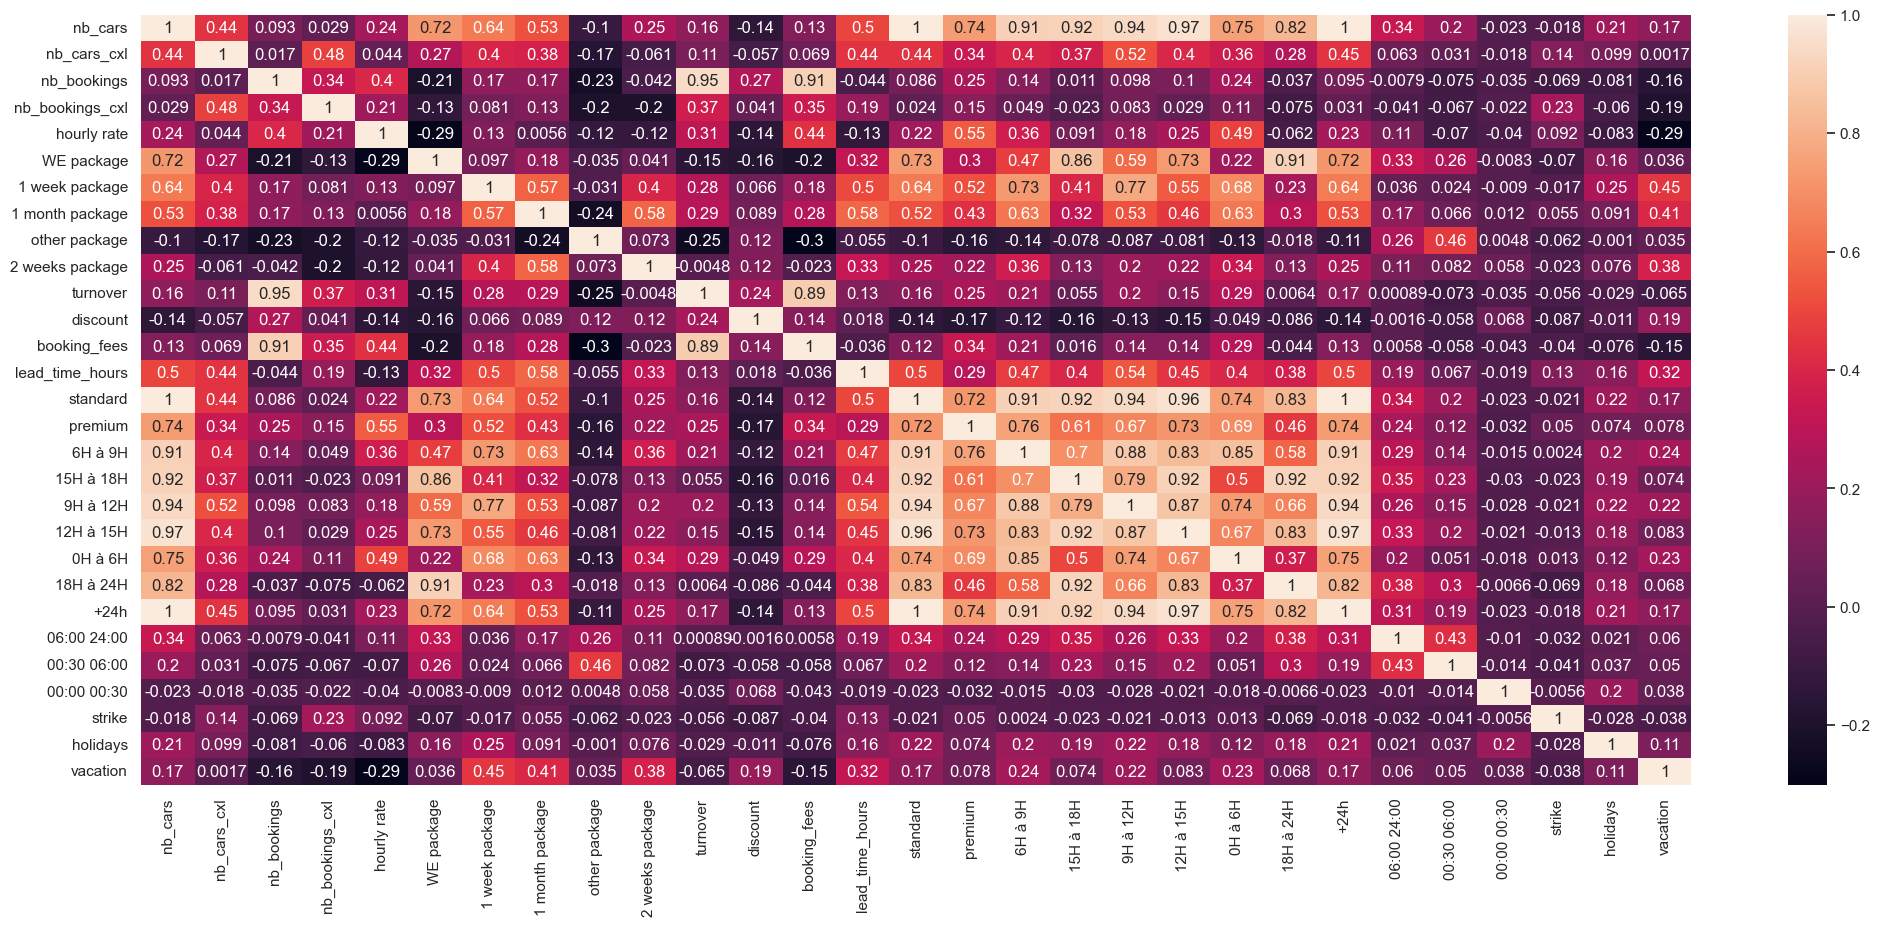

In [106]:

# Calculez la matrice de corrélation
corr_matrix = numeric_cols.corr()

# Affichez la heatmap
sns.heatmap(corr_matrix, annot=True)
plt.show()

## VIF

In [107]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [110]:
features = df_minmax_scaled[['nb_cars', 'nb_cars_cxl', 'nb_bookings', 'nb_bookings_cxl',
       'hourly rate', 'WE package', '1 week package', '1 month package',
       'other package', '2 weeks package', 'turnover', 'discount',
       'booking_fees', 'lead_time_hours', 'standard', 'premium', '6H à 9H',
       '15H à 18H', '9H à 12H', '12H à 15H', '0H à 6H', '18H à 24H', '+24h',
       '06:00 24:00', '00:30 06:00', '00:00 00:30', 'strike', 'holidays',
       'vacation']]

In [111]:
features = sm.add_constant(features)

In [113]:
vif = pd.DataFrame()
vif["Features"] = features.columns
vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
vif

/Users/annettbehr/.pyenv/versions/3.10.6/envs/carpark_forecast/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/annettbehr/.pyenv/versions/3.10.6/envs/carpark_forecast/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Features,VIF
0,const,0.000000
1,nb_cars,inf
2,nb_cars_cxl,2.420062
3,nb_bookings,18.980686
4,nb_bookings_cxl,1.906059
5,hourly rate,inf
6,WE package,inf
7,1 week package,inf
8,1 month package,inf
9,other package,inf
